# Notebook para generar gráficos finales
## <a id="Plots_index">Índice de gráficos:</a>
- [Ejemplo de Horas Observadas](#Observed_Hours)
- [Algunos Resultados de Horas Observadas](#Some_Observed_Hours_Results)
- [Algunos Histogramas de Densidad Hexbin](#Some_Hexbin)
- [Gráficos de Dispersión para las Métricas de Salidas del Modelo](#Scatter_Metrics_for_Model_Outputs)
  - MAE, RMSE, R2, Índice de Correlación, Índice de Concordancia
- [Gráficos de Barras Promediando Métricas por Estaciones](#Bar_Charts_Averaging_Metrics_over_Stations)
  - MAE, RMSE, R2, Índice de Correlación, Índice de Concordancia
- [Gráficos de Barras Promediando Métricas por Horas](#Bar_Charts_Averaging_Metrics_over_Hours)
  - MAE, RMSE, R2, Índice de Correlación, Índice de Concordancia
- [Gráficos de Dispersión de Errores de 24h](#Scatter_Plots_of_24h_Error_Graphics)
  - Máximo, Promedio
- [Gráficos de Barras de Errores de 24h por Estaciones](#Bar_Charts_of_24h_Errors_over_Stations)
  - Máximo, Promedio
- [Tabla de Results_df](#Results_df_Table)
- [Ajuste de Histograma](#Histogram_Fit)
- [Tabla de Resultados Generales](#Overall_Results_Table)

In [1]:
# Variable params
string_test = "4paper_test01_15x3_5btsp_24ph_v20"
hours_before = 24 # How many hours of pollution data are we adding as input to the model (current - hours_before)
bootstrap = True
boostrap_factor = 15  # Number of times to repeat the bootstrap
boostrap_threshold = 2.9
meteo_vars = True

In [2]:
# Fixed params for notebook:
#
# Check additional configuration data (get_makeprediction_config,...)
# in conf/TrainingUserConfiguration.py

# for copy training_results_folder  from training notebook
training_results_folder = '/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019'
INPUT_SIZE = 3450 #copy(config[ModelParams.INPUT_SIZE])

In [3]:
import os
import pickle
import sys
import time
from datetime import date, datetime, timedelta
from copy import copy, deepcopy
from os import listdir

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from matplotlib.colors import LogNorm
from pandas import DataFrame
from sklearn import preprocessing
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from AI.data_generation.utilsDataFormat import *
from ai_common.constants.AI_params import *
#from ai_common.constants.AI_params import NormParams, TrainingParams, ModelParams
import ai_common.training.trainingutils as utilsNN
from ai_common.models.modelSelector import select_1d_model
from conf.MakeWRF_and_DB_CSV_UserConfiguration import getPreprocWRFParams
from conf.TrainingUserConfiguration import getTrainingParams, get_makeprediction_config
from conf.localConstants import constants
from conf.params import LocalTrainingParams, PreprocParams
from os.path import join
from proj_io.inout import create_folder, add_forecasted_hours, add_previous_hours, filter_data, get_column_names, read_merged_files, save_columns
from proj_preproc.preproc import apply_bootstrap, normalizeData, loadScaler, extract_model_name
from proj_prediction.prediction import analyze_column, scatter_plot_by_column, compile_scaler, average_metric, average_metric_by_hour, analyze_multi_hour_plot, plot_max_difference, plot_forecast_hours, plot_max_and_mean_difference, calculate_imeca
from viz.figure_generator import plot_input_output_data


# Filtering warnings:
import warnings

warnings.filterwarnings("ignore", message="DataFrame is highly fragmented")
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter out INFO, 2 = filter out WARNING and INFO, 3 = filter out ERROR, WARNING, and INFO



In [4]:
# In case we want to save the columns to temporal files for debugging purposes
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [5]:
config = getTrainingParams()
stations = config[LocalTrainingParams.stations]
pollutants = config[LocalTrainingParams.pollutants]
start_year = 2010
end_year = 2019
cur_pollutant = 'otres'
cur_station = 'MER'

input_folder = config[TrainingParams.input_folder]
output_folder = config[TrainingParams.output_folder]
output_folder = join(output_folder,F"{string_test}_{start_year}_{end_year}")
val_perc = config[TrainingParams.validation_percentage]
test_perc = config[TrainingParams.test_percentage]
eval_metrics = config[TrainingParams.evaluation_metrics]
loss_func = config[TrainingParams.loss_function]
batch_size = config[TrainingParams.batch_size]
epochs = config[TrainingParams.epochs]
model_name_user = config[TrainingParams.config_name]
optimizer = config[TrainingParams.optimizer]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
norm_type = config[TrainingParams.normalization_type]

split_info_folder = join(output_folder, 'Splits')
parameters_folder = join(output_folder, 'Parameters')
weights_folder = join(output_folder, 'models')
logs_folder = join(output_folder, 'logs')
imgs_folder= join(output_folder, 'imgs')
norm_folder = join(output_folder, 'norm')

create_folder(split_info_folder)
create_folder(parameters_folder)
create_folder(weights_folder)
create_folder(logs_folder)
create_folder(norm_folder)
create_folder(imgs_folder)


# Evaluation

In [6]:
print(training_results_folder,INPUT_SIZE, sep="\n")


/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019
3450


In [7]:
# In case we want to save the columns to temporal files for debugging purposes
#os.environ["CUDA_VISIBLE_DEVICES"] = "" # If there is no cuda available usually not needed on this notebook

config = get_makeprediction_config()

# *********** Read parameters ***********
input_file = config[ClassificationParams.input_file]
output_folder = f'{config[ClassificationParams.output_folder]}'
output_imgs_folder = config[ClassificationParams.output_imgs_folder]
output_file_name = config[ClassificationParams.output_file_name]
model_weights_file = config[ClassificationParams.model_weights_file]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
pollutant = config[LocalTrainingParams.pollutants][0]

# ********** Reading and preprocessing data *******
all_stations = [
    "UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM",
    "IZT", "CCA", "HGM", "LPR", "MGH", "CAM", "FAC", "TLA", "MER", "XAL",
    "LLA", "TLI", "UAX", "BJU", "MPA", "MON", "NEZ", "INN", "AJM", "VIF"
]

# Small set of stations, hours to evalaute some cases 
evaluate_stations = ["UIZ", "AJU", "ATI", "UAX"]
evaluate_hours = [1, 6, 12, 18, 24]

# Iterate over the stations
models_folder = '/ZION/AirPollutionData/Data/Training/cont_otres_UIZ/models/'
data_folder = '/ZION/AirPollutionData/Data/MergedDataCSV/16/'

test_year = 2019
# file with testing dataset with test_year
hardcoded_input_file = f'/ZION/AirPollutionData/Data/MergedDataCSV/16/{test_year}_AllStations.csv'

# %%
# cur_station fixed value to get statistics for bootstrapping
cur_station = 'MER'

# %% Para arreglar variables hardcodeadas:
# %% Extract model name from weights file_names.hdf5
models_path = join(training_results_folder, 'models')
model_name = extract_model_name(models_path)
print(model_name)


# path to normalization data stored
norm_folder = join(training_results_folder,'norm')
imgs_folder = training_results_folder
path_csvs = training_results_folder

print(f"""training_results_folder:{training_results_folder}
model_name:{model_name}
hardcoded_input_file:{hardcoded_input_file}
norm_folder:{norm_folder}
imgs_folder:{imgs_folder}
path_csvs:{path_csvs}
""")

print(f"""input_file:{input_file}
output_folder:{output_folder}
output_imgs_folder:{output_imgs_folder}
output_file_name:{output_file_name}
model_weights_file:{model_weights_file}
forecasted_hours:{forecasted_hours}
pollutant:{pollutant}
""")


TestsPS_4paper_otres_2023_11_14_01_33
training_results_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019
model_name:TestsPS_4paper_otres_2023_11_14_01_33
hardcoded_input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2019_AllStations.csv
norm_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019/norm
imgs_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019
path_csvs:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019

input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2015_cont_otres_AllStations.csv
output_folder:/ZION/AirPollutionData/Data/Results
output_imgs_folder:/ZION/AirPollutionData/Data/Results/TestOZ
output_file_name:/ZION/AirPollutionData/TrainingTESTOZ/Results/TestOZ.csv
model_weights_file:/ZION/AirPollutionData/TrainingTESTOZ/models
forecasted_hours:24
pollutant:otres



In [8]:
# %% Definitions of folders where images and data will be exported

output_results_folder = join(output_imgs_folder, model_name)
output_results_folder_img = join(output_results_folder, 'imgs')
output_results_folder_data = join(output_results_folder, 'data')

create_folder(output_results_folder)
create_folder(output_results_folder_img)
create_folder(output_results_folder_data)


In [9]:
model_name_user = config[TrainingParams.config_name]
print(model_name_user)
print(output_folder)

TestOZ
/ZION/AirPollutionData/Data/Results


In [10]:
#%% Loading the best weight file on the weights folder
path_model_weights = join(f'{training_results_folder}',f'models')
print(path_model_weights)

model_weights_file = join(path_model_weights,f'{model_name}*')
weight_files = glob.glob(model_weights_file)
lista_weights =[]
for item in weight_files:
    lista_weights.append(float(item.split('/')[-1].split('-')[-1].split('.hdf5')[0]))
print(lista_weights)
model_weights_file = glob.glob(join(path_model_weights,f'{model_name}*{min(lista_weights)}*'))
model_weights_file = model_weights_file[0]
assert len(model_weights_file) > 0
print(f'\nModel weight file to use of    {min(lista_weights)}: \n\n',model_weights_file)

/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019/models
[0.6035378, 0.56642407, 0.5302577, 0.43525407, 0.36179197, 0.32665047, 0.31272238, 0.30621785, 0.30049142, 0.29688501, 0.29235762, 0.28878742, 0.28336212, 0.28049308, 0.27818382, 0.27597681, 0.27464828, 0.2721507, 0.27201834, 0.26983255, 0.26947716, 0.26739654, 0.26627365, 0.2655074, 0.26438257, 0.26381394, 0.26331496, 0.26196802, 0.26072904, 0.26069912, 0.26004851, 0.25991949, 0.25848687, 0.25844783]

Model weight file to use of    0.25844783: 

 /ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019/models/TestsPS_4paper_otres_2023_11_14_01_33-epoch-41-loss-0.25844783.hdf5


In [11]:
#%% data test file
input_file = hardcoded_input_file
assert len(input_file) > 0
data = pd.read_csv(input_file, index_col=0)

In [12]:
# Remove meteo ?
import re
if not meteo_vars:
    regex_list = ['U10.*', 'V10.*','RAINC.*', 'T2.*', 'RAINNC.*', 'SWDOWN.*', 'GLW.*']
    filtered_data = data.filter(regex='^(?!(%s)).*$' % '|'.join(regex_list))
    print(filtered_data)
    data = filtered_data


In [13]:
#%% Redo the test dataset data as in the hot vectors used during training.

datetimes_str = data.index.values
datetimes = np.array([
    datetime.strptime(x, constants.datetime_format.value)
    for x in datetimes_str
])


In [14]:
# %% -------- Normalizing data
# loading of original scaler object
file_name_norm = join(norm_folder,F"{model_name}_scaler.pkl")  
scaler = loadScaler(file_name_norm)


In [15]:
# %% compiling a scale according to data
new_scaler_cols = data.columns.tolist()
old_features = scaler.feature_names_in_.tolist()
#print(old_features)


In [16]:
# %%
prefijo = 'plusfake_x_' #dummy prefix hack
new_scaler_cols = [prefijo + elemento for elemento in new_scaler_cols]
new_scaler = compile_scaler(scaler,new_scaler_cols)

In [17]:
#%%
print("Normalizing data....")
data_norm_np = new_scaler.transform(data)
data_norm_df = DataFrame(data_norm_np, columns=data.columns, index=data.index)
#print(data_norm_df)

Normalizing data....


In [18]:
#%% Continuing to get the input vector format

# %% ====== Getting all the orignal columns by type
all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(data_norm_df)

# %% ====== Remove columns for other pollutants

cur_pollutant = 'otres'
X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                   filtered_pollutant=cur_pollutant) 

print(X_df.columns.values)
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')

# %% ====== Adding the previous hours of the pollutants as extra columns (all contaminants)
print(F"Building X and Y ....")
X_df = add_previous_hours(X_df, hours_before)

# %% ====== Adding the forecasted hours of the pollutants as the predicted column Y (specific contaminant)
print("\tAdding the forecasted hours of the pollutant as the predicted column Y...")
Y_df = add_forecasted_hours(X_df, cur_pollutant, range(1,forecasted_hours+1))

# %% Remove the first hours because Print the final shape of X and Y
X_df = X_df.iloc[hours_before:,:]
Y_df = Y_df.iloc[hours_before:,:]
print("Done!")

print(F'Original {data_norm_df.shape}')
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')
print(F'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum()/1024**2:02f} MB')


# %%
print("Removing time index...")
X_df.reset_index(drop=True, inplace=True)
Y_df.reset_index(drop=True, inplace=True)

#%% Replace all the nan values with another value
replace_value = 0
print(f"Replacing nan values with {replace_value}...")
X_df.fillna(replace_value, inplace=True)
# Vamos conservar los nan de Y_df en este caso
# Y_df.fillna(replace_value, inplace=True)


Keeping columns: 2730 original columns: 2925
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' ... 'GLW_13_h23'
 'GLW_14_h23' 'GLW_15_h23']
X (8761, 2730), Memory usage: 182.543114 MB
Building X and Y ....
	Adding the previous hours of the pollutants as additional columns...
X (8761, 3450), Memory usage: 230.668724 MB
Done!
	Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (8761, 720)
Done!
Done!
Original (8761, 2925)
X (8737, 3450), Memory usage: 230.036827 MB
Y (8737, 720), Memory usage: 48.060432 MB
Removing time index...
Replacing nan values with 0...


In [19]:
# %% Visualize input and outputs

#print("Visualizing input and outputs...")
#plot_input_output_data(X_df, Y_df, cur_station, cur_pollutant, 
#                       output_results_folder_img, model_name) # previously used imgs_folder


In [20]:
# %% *********** Chooses the proper model and weights ***********

# %% Loading csv with X an Y columns
X_cols_csv = pd.read_csv( join(path_csvs, 'X_columns.csv'))
Y_cols_csv = pd.read_csv( join(path_csvs, 'Y_columns.csv'))

X_cols = X_cols_csv['0'].tolist()
Y_cols = Y_cols_csv['0'].tolist()


# %% ******************* Selecting the model **********************

config[ModelParams.INPUT_SIZE] = INPUT_SIZE
config[ModelParams.NUMBER_OF_OUTPUT_CLASSES] = len(Y_cols)

print('Reading model ....')
model = select_1d_model(config)


# *********** Reads the weights***********
print('Reading weights ....')
model.load_weights(model_weights_file)


# %% Calculo de predicciones de el dataset de test:
Y_pred = model.predict(X_df.values)

# %% A funciton is defined to generate custom scaler objects
scaler_y = compile_scaler(scaler,Y_cols)


#%% Desescalar de predicciones y y_true, y su procesado
Y_pred_descaled = scaler_y.inverse_transform(Y_pred)
y_pred_descaled_df = pd.DataFrame(Y_pred_descaled,
                                  columns=scaler_y.feature_names_in_)
#print(y_pred_descaled_df.head())

y_true_df = pd.DataFrame(scaler_y.inverse_transform(Y_df),
                         columns=Y_df.columns)

#print(y_true_df.head())

# %% 
params_grid = [(f'plus_{hour:02}_cont_{cur_pollutant}_{cur_station}')
               for cur_station in evaluate_stations for hour in evaluate_hours]




Reading model ....
Reading weights ....


## <a id="Observed_Hours">Ejemplo de Horas Observadas</a>
- [Return to Plots Index](#Plots_index)  

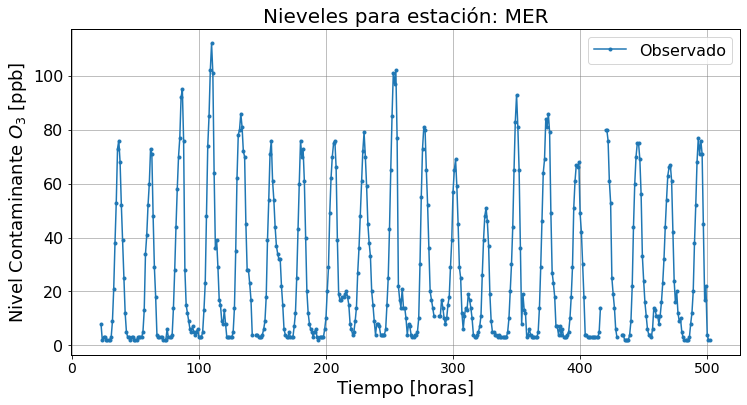

In [21]:
import matplotlib.pyplot as plt

def plot_simple(x_plot, y_true_column, title='Gráfica Simple', x_label='Eje X', y_label='Eje Y'):
    """
    Genera una gráfica simple de los datos proporcionados.

    Parámetros:
    x_data (iterable): Datos para el eje X.
    y_data (iterable): Datos para el eje Y.
    title (str): Título de la gráfica.
    x_label (str): Etiqueta para el eje X.
    y_label (str): Etiqueta para el eje Y.
    """
    plot_this_many = 24 * 20  # Number of points to plot

    plt.close('all')
    fig, ax = plt.subplots(figsize=[12, 6])

    ax.plot(x_plot[0:plot_this_many], y_true_column[0:plot_this_many], marker='.', label='Observado')

    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.set_title(title, fontsize=20)

    # Configurar la cuadrícula
    ax.grid(True, color='grey', linestyle='-', linewidth=0.5)

    # Configurar los bordes (spines) de la gráfica
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.)

    ax.legend(fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)

    plt.show()

# Use example of observed Hours for introduction sections

y_true_column = y_true_df['plus_01_cont_otres_MER']
x_plot  = range(23, 23 + len(y_true_column))

# plot_simple(x_plot, y_true_column, title='Niveles Observados para la Estación: MER', x_label='Tiempo [horas]', y_label='Nivel de Contaminante $O_3$ [ppb]')
plot_simple(x_plot, y_true_column, title='Nieveles para estación: MER', x_label='Tiempo [horas]', y_label='Nivel Contaminante $O_3$ [ppb]')


In [22]:
#print(y_true_df)
#print(y_pred_descaled_df)

In [23]:
#y_true_df.to_csv('./)

## <a id="Some_Observed_Hours_Results">Algunos Resultados de Horas Observadas</a>
- [Return to Plots Index](#Plots_index)  

plus_01_cont_otres_UIZ


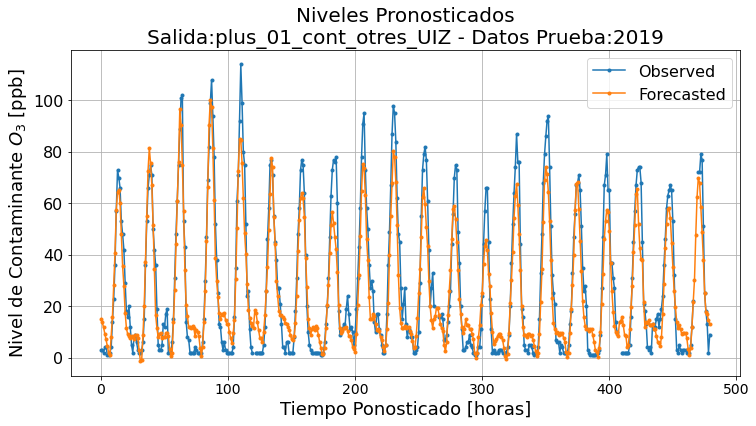

plus_06_cont_otres_UIZ


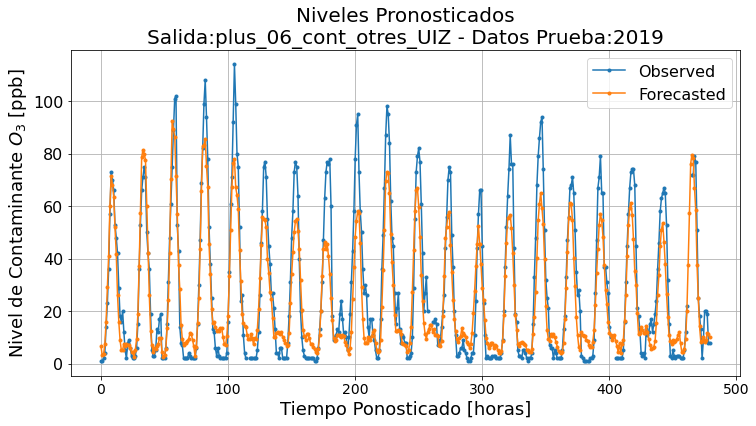

plus_12_cont_otres_UIZ


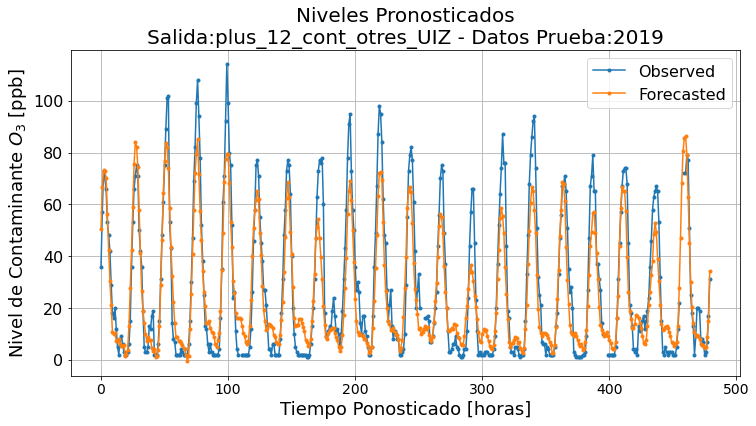

plus_18_cont_otres_UIZ


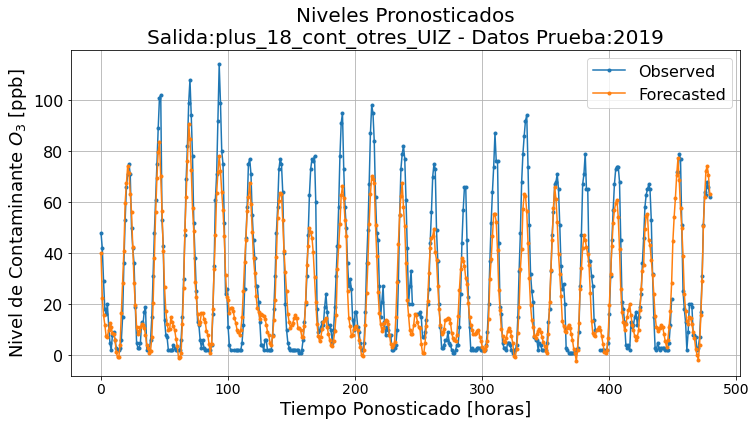

plus_24_cont_otres_UIZ


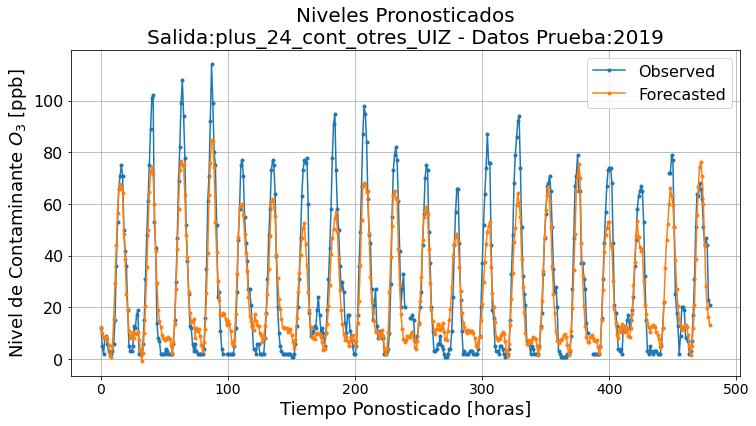

plus_01_cont_otres_AJU


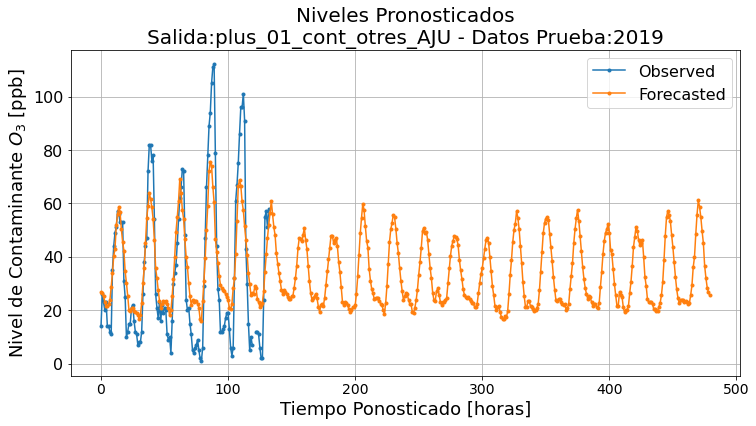

plus_06_cont_otres_AJU


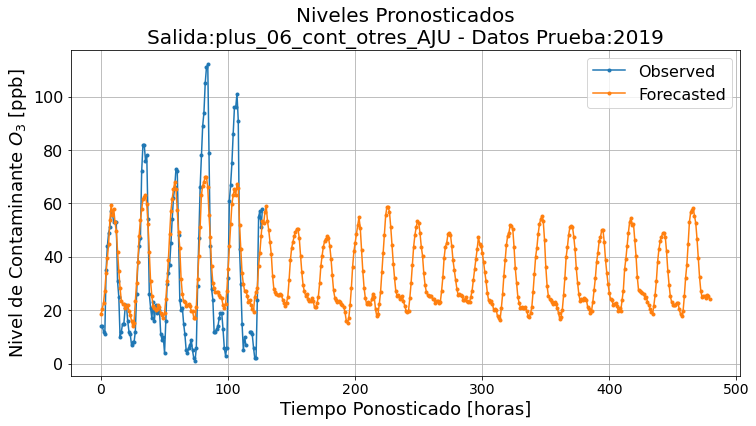

plus_12_cont_otres_AJU


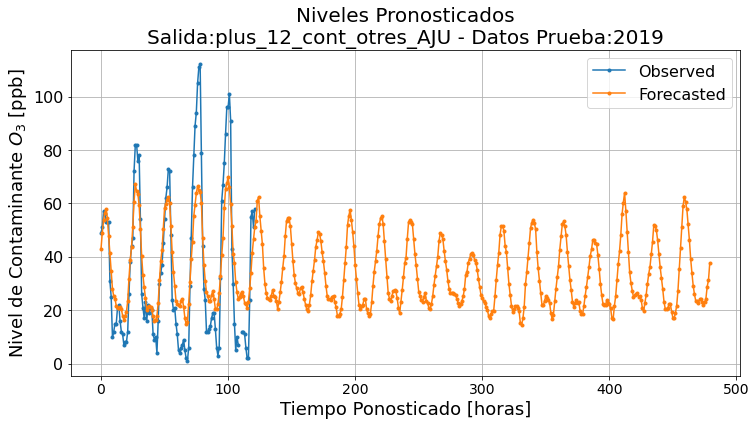

plus_18_cont_otres_AJU


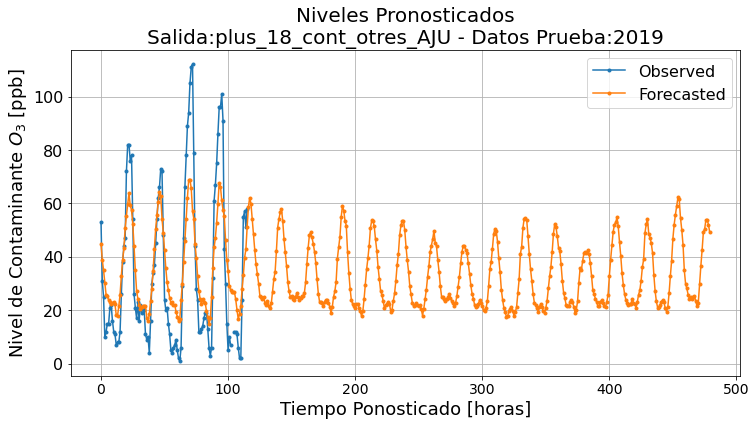

plus_24_cont_otres_AJU


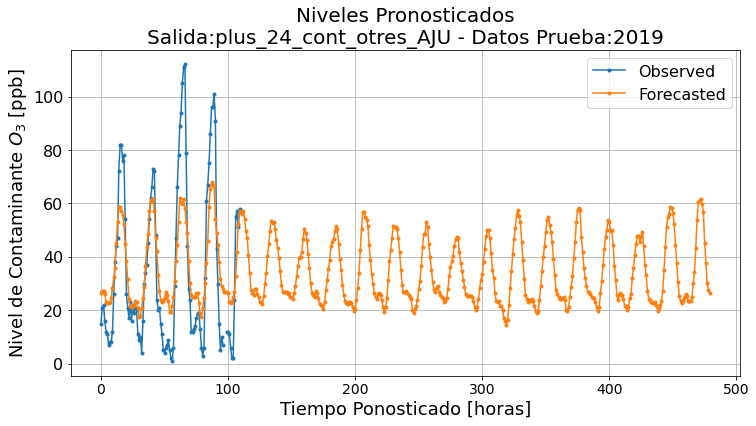

plus_01_cont_otres_ATI


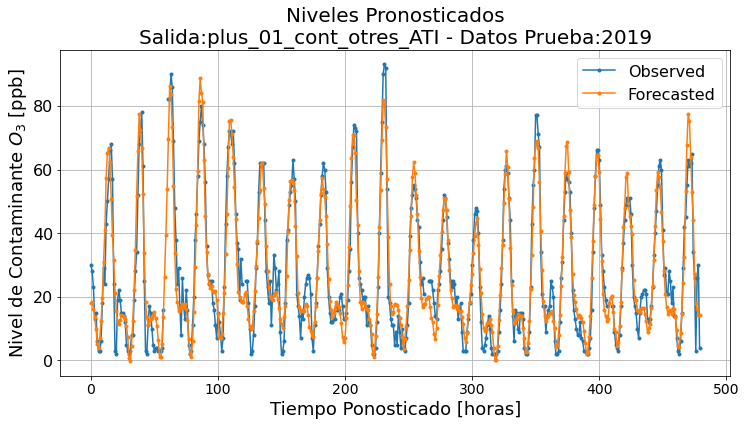

plus_06_cont_otres_ATI


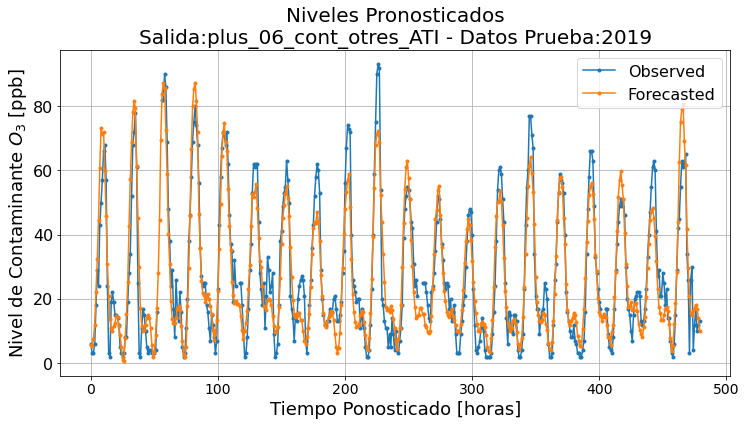

plus_12_cont_otres_ATI


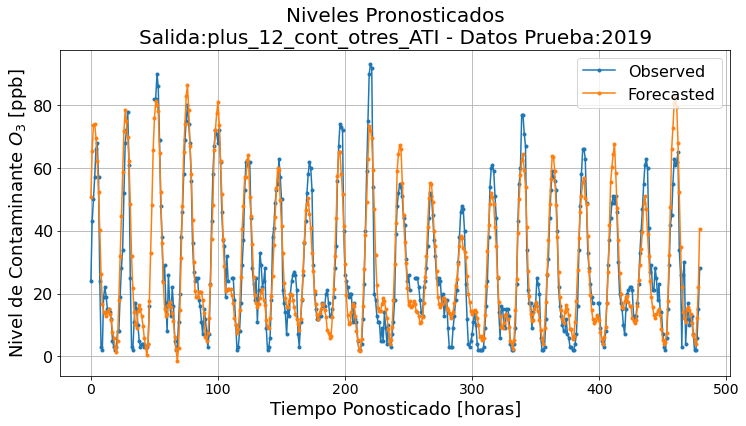

plus_18_cont_otres_ATI


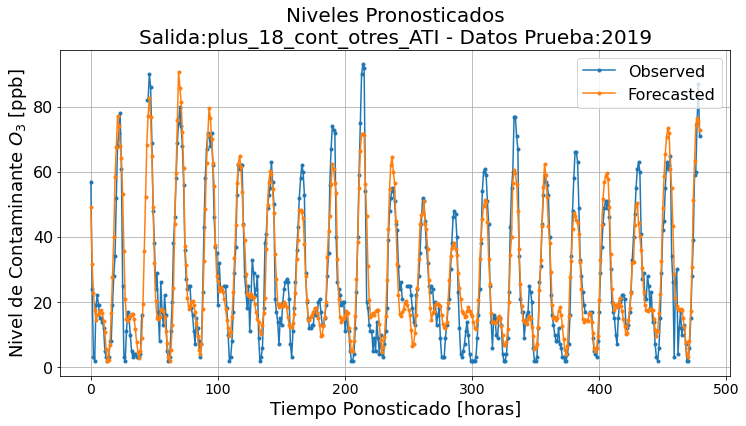

plus_24_cont_otres_ATI


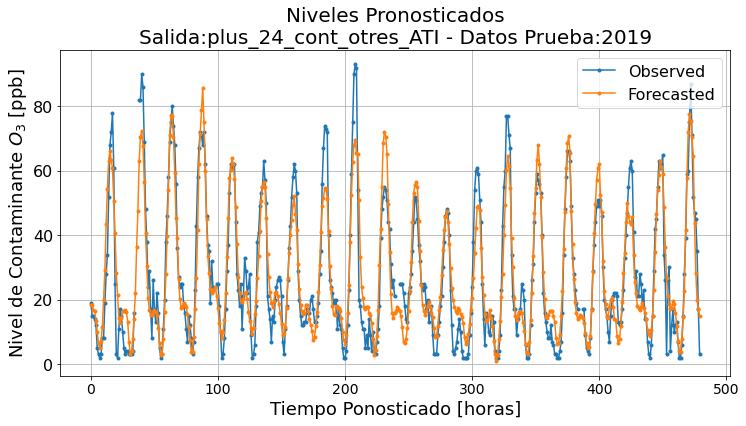

plus_01_cont_otres_UAX


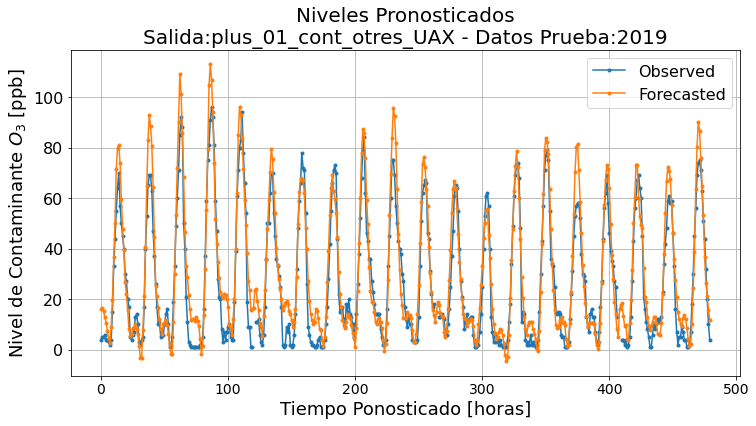

plus_06_cont_otres_UAX


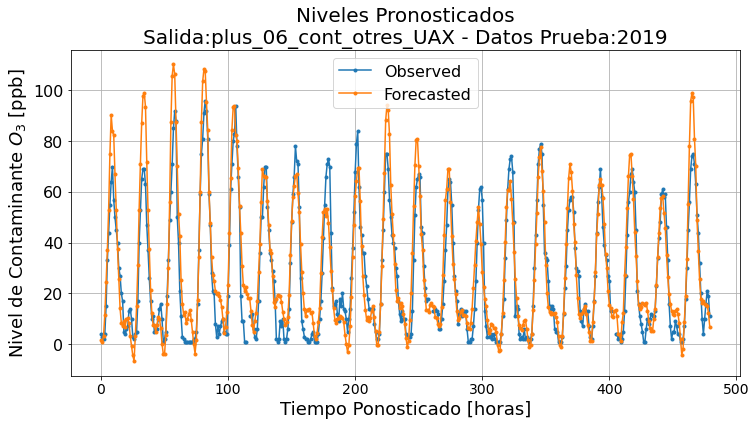

plus_12_cont_otres_UAX


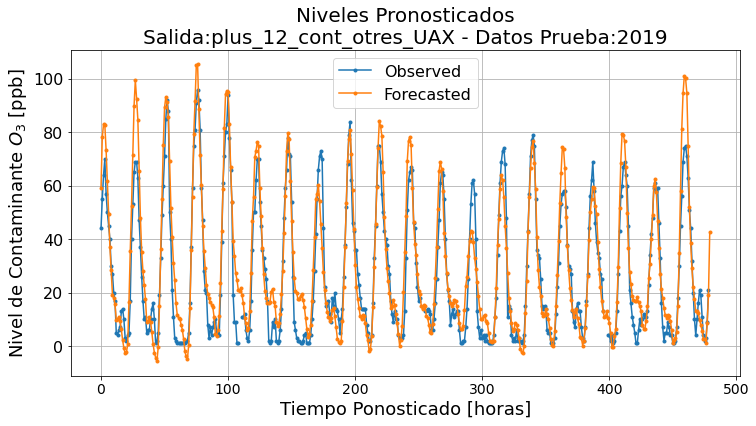

plus_18_cont_otres_UAX


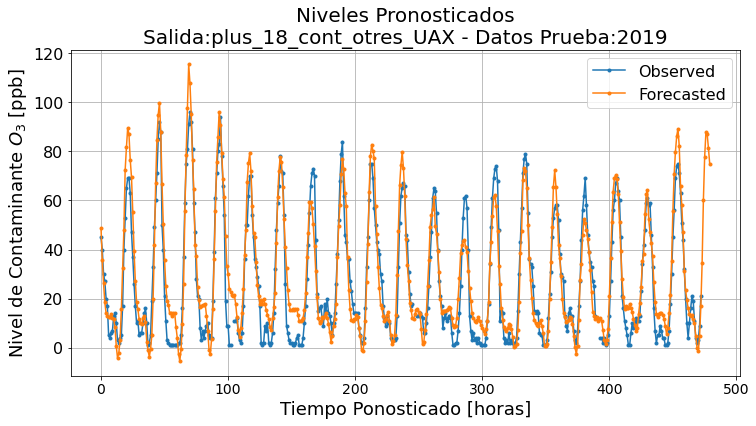

plus_24_cont_otres_UAX


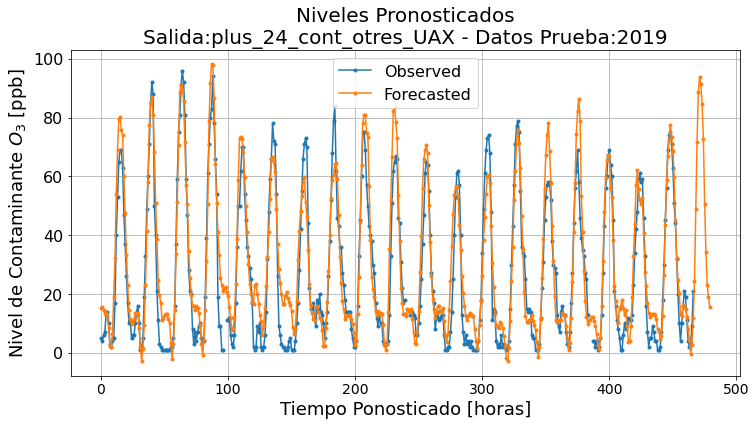

In [24]:
import matplotlib.pyplot as plt
from os.path import join

def plot_forecast_hours(column_to_plot, y_true_df, y_pred_descaled_df, 
                        output_results_folder_img=None, show_grid=True, 
                        x_label='Forecasted Time [hours]', y_label='Pollutant Level $O_3$ [ppb]', 
                        title_str=None, save_fig=True):
    """
    Generate a plot for forecast hours.

    Parameters:
    ...
    """
    plt.close('all')
    plot_this_many = 24 * 20  # Number of points to plot
    
    # Retrieve columns for plotting
    y_true_column = y_true_df[column_to_plot]
    y_pred_column = y_pred_descaled_df[column_to_plot]
    
    x_plot = range(len(y_true_column))
    
    # Plotting
    plt.figure(figsize=[12, 6])
    
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    
    plt.plot(x_plot[0:plot_this_many], y_true_column[0:plot_this_many], marker='.', label='Observed')
    plt.plot(x_plot[0:plot_this_many], y_pred_column[0:plot_this_many], marker='.', label='Forecasted')
    
    if title_str is not None:
        plt.title(title_str, fontsize=20)
    else:
        plt.title(f'Forecast Levels for {column_to_plot}', fontsize=20)
        
    if show_grid:
        plt.grid(True)
    
    plt.legend(fontsize=16)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=16)
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'hours_plot_{column_to_plot.lower()}.png'), dpi=300)
    
    plt.show()

# Ploting forecast and observed hours on dataset

plt.close('all')

for cur_column in params_grid:
    print(cur_column)
    
    # Llamar a la función con la columna deseada y argumentos adicionales
    plot_forecast_hours(
        cur_column, 
        y_true_df, 
        y_pred_descaled_df, 
        output_results_folder_img=output_results_folder_img,
        show_grid=True, 
        x_label='Tiempo Ponosticado [horas]', 
        y_label='Nivel de Contaminante $O_3$ [ppb]',
        title_str=f'Niveles Pronosticados\nSalida:{cur_column} - Datos Prueba:2019',
        save_fig=True
    )


## <a id="Some_Hexbin">Some Hexbin Density Histograms</a>
- [Return to Plots Index](#Plots_index)  

column name:plus_01_cont_otres_UIZ
Correlation index:                     0.9362


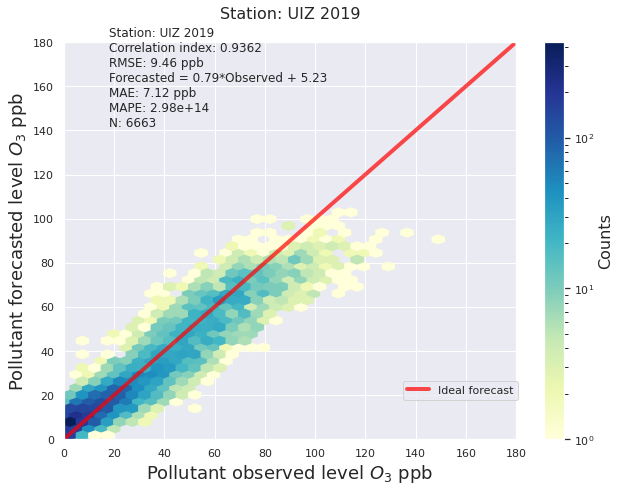

column name:plus_06_cont_otres_UIZ
Correlation index:                     0.8914


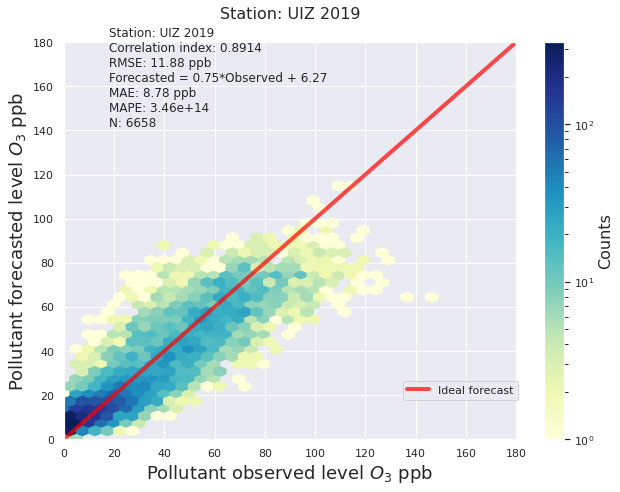

column name:plus_12_cont_otres_UIZ
Correlation index:                     0.8959


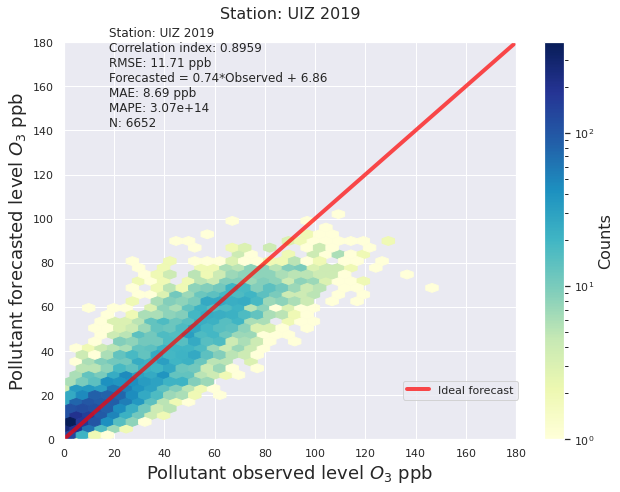

column name:plus_18_cont_otres_UIZ
Correlation index:                     0.8953


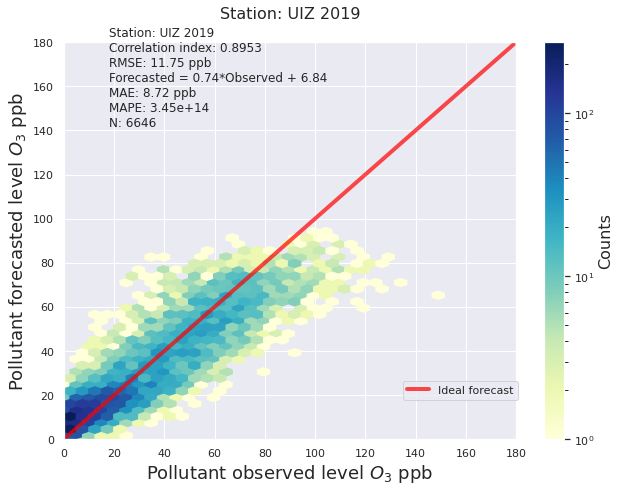

column name:plus_24_cont_otres_UIZ
Correlation index:                     0.8828


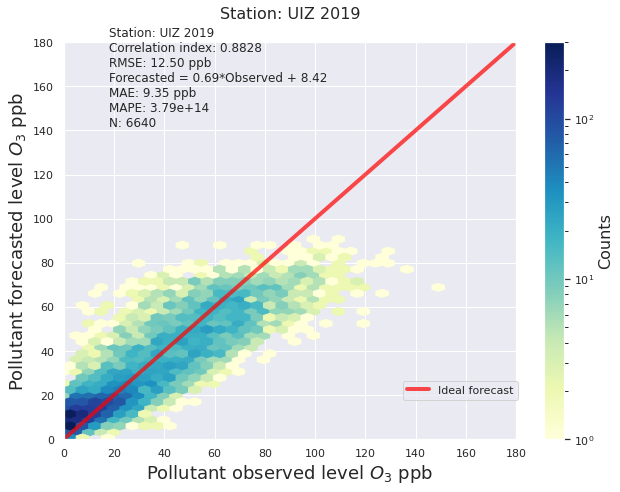

column name:plus_01_cont_otres_AJU
Correlation index:                     0.8932


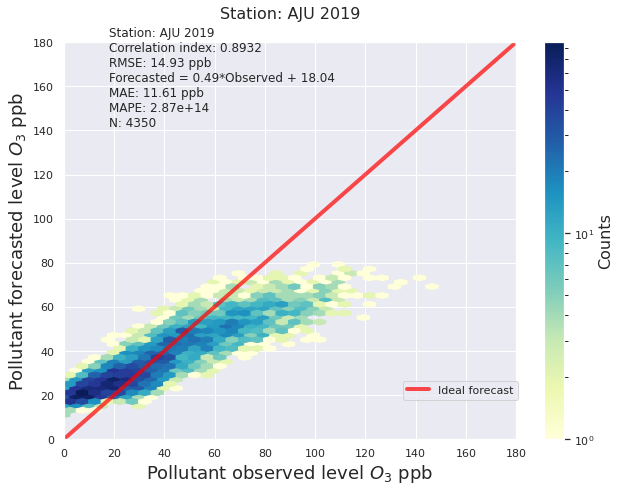

column name:plus_06_cont_otres_AJU
Correlation index:                     0.8628


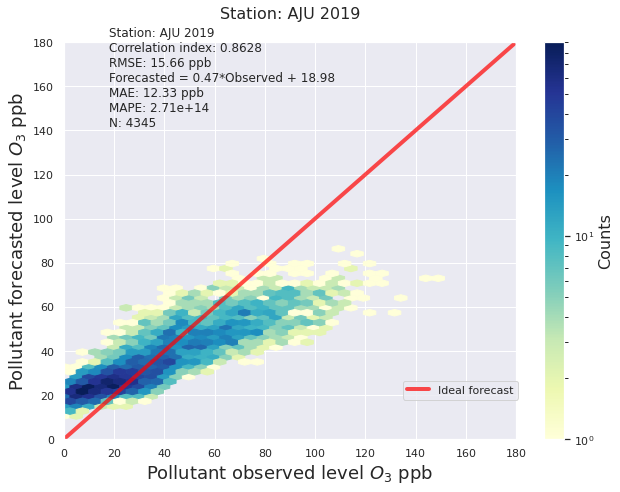

column name:plus_12_cont_otres_AJU
Correlation index:                     0.8603


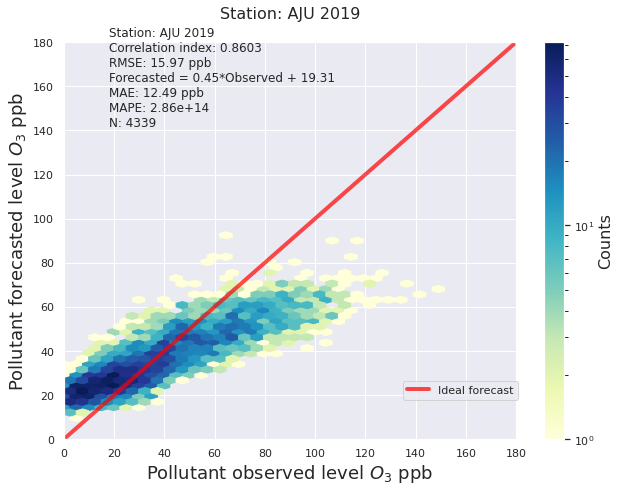

column name:plus_18_cont_otres_AJU
Correlation index:                     0.8583


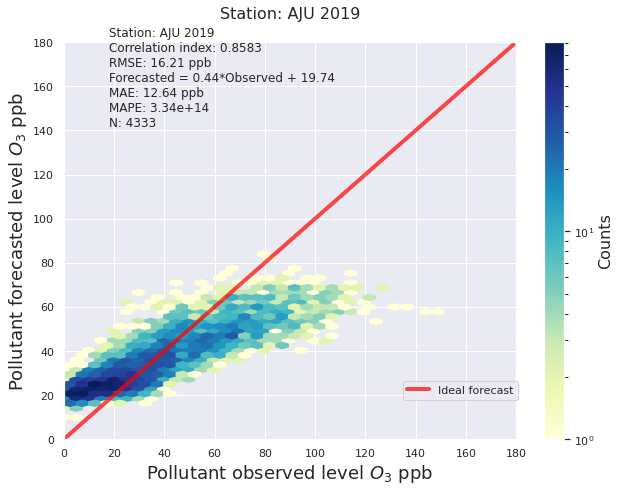

column name:plus_24_cont_otres_AJU
Correlation index:                     0.8414


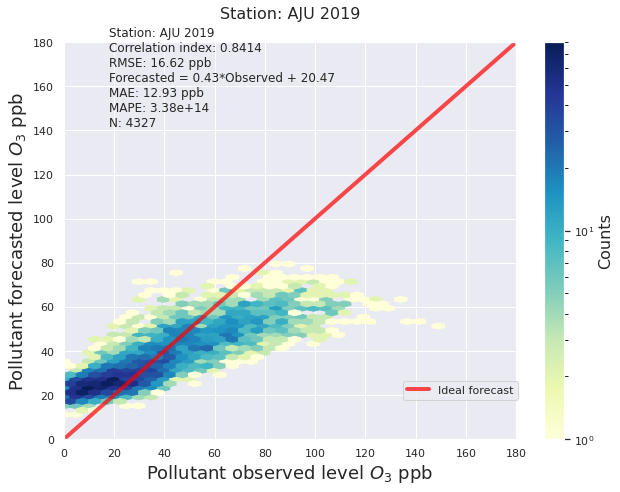

column name:plus_01_cont_otres_ATI
Correlation index:                     0.9282


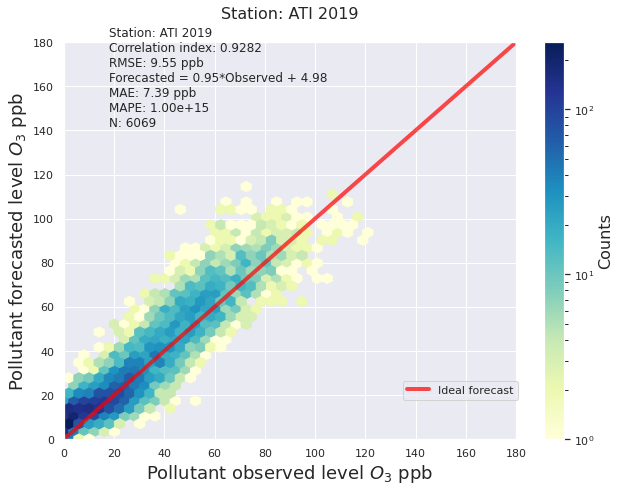

column name:plus_06_cont_otres_ATI
Correlation index:                     0.8853


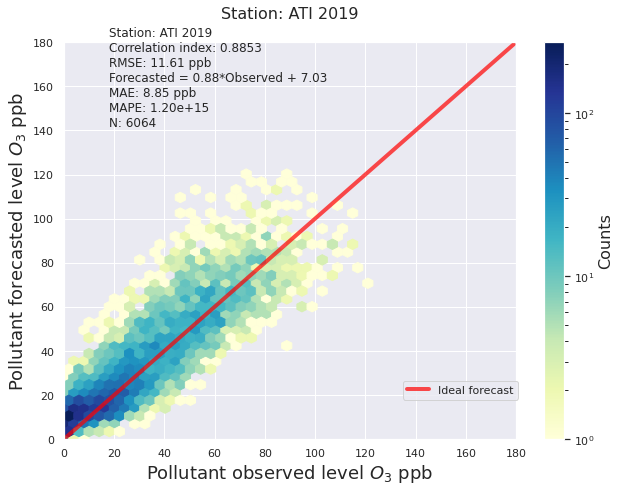

column name:plus_12_cont_otres_ATI
Correlation index:                     0.8811


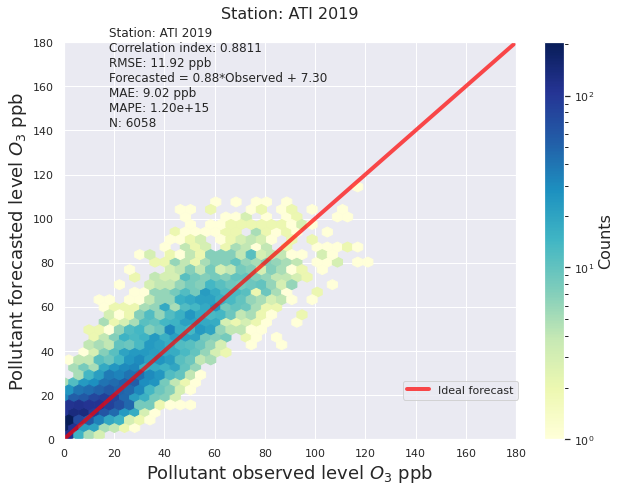

column name:plus_18_cont_otres_ATI
Correlation index:                     0.8803


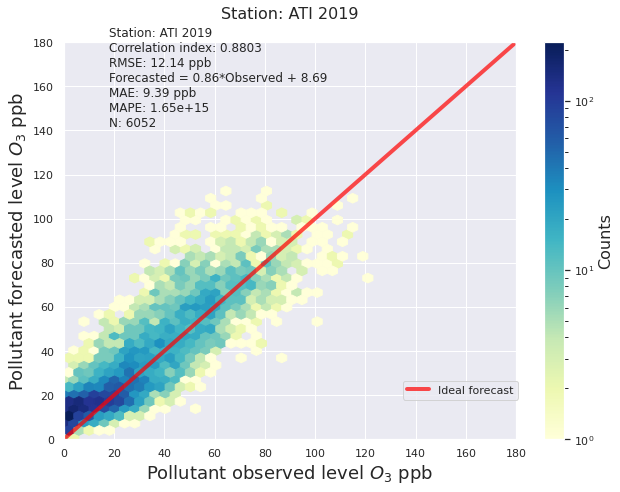

column name:plus_24_cont_otres_ATI
Correlation index:                     0.8796


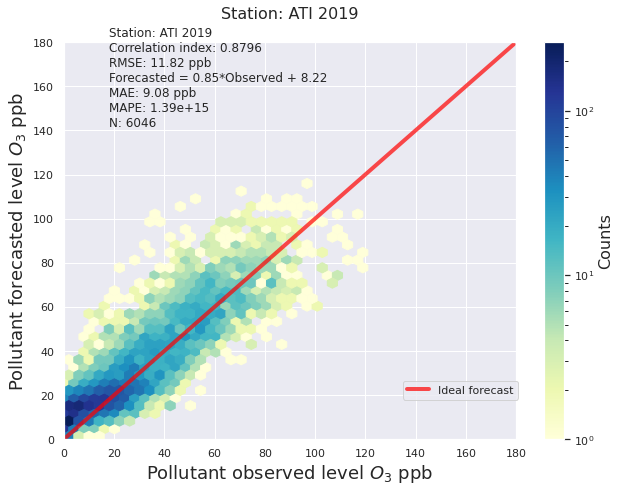

column name:plus_01_cont_otres_UAX
Correlation index:                     0.9091


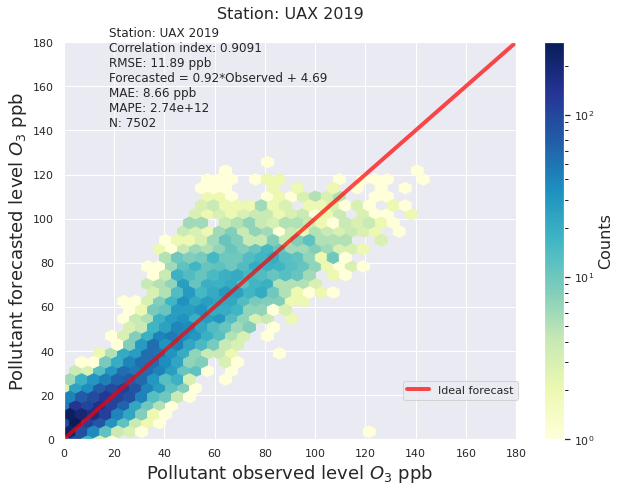

column name:plus_06_cont_otres_UAX
Correlation index:                     0.8794


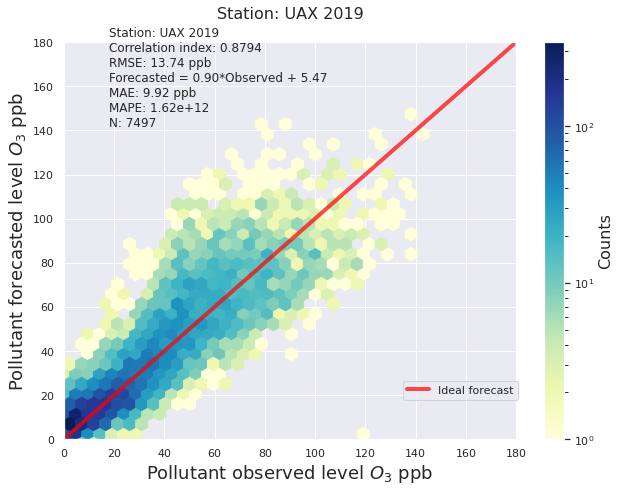

column name:plus_12_cont_otres_UAX
Correlation index:                     0.8735


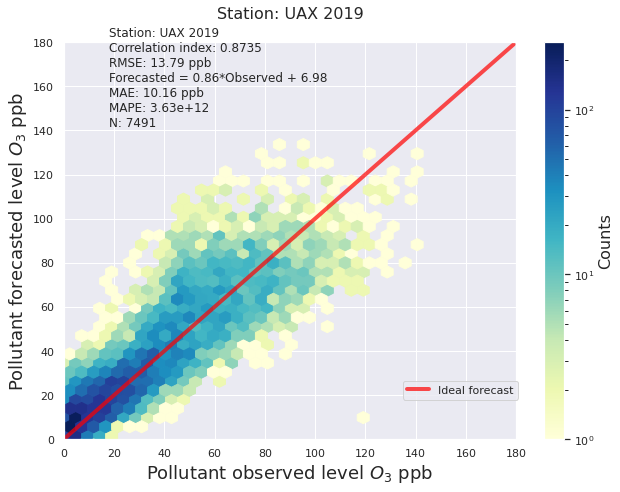

column name:plus_18_cont_otres_UAX
Correlation index:                     0.8719


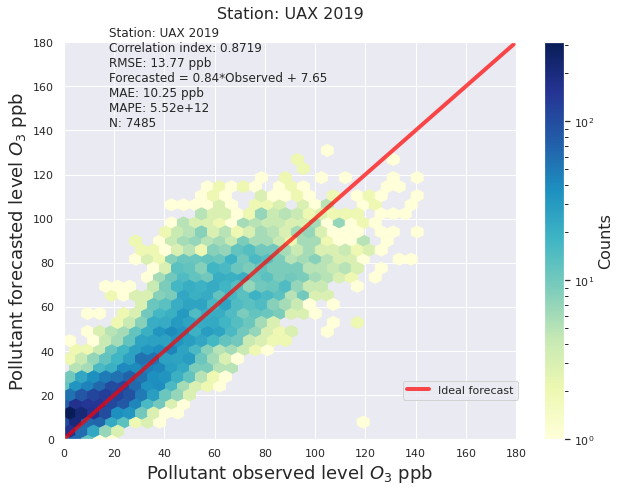

column name:plus_24_cont_otres_UAX
Correlation index:                     0.8636


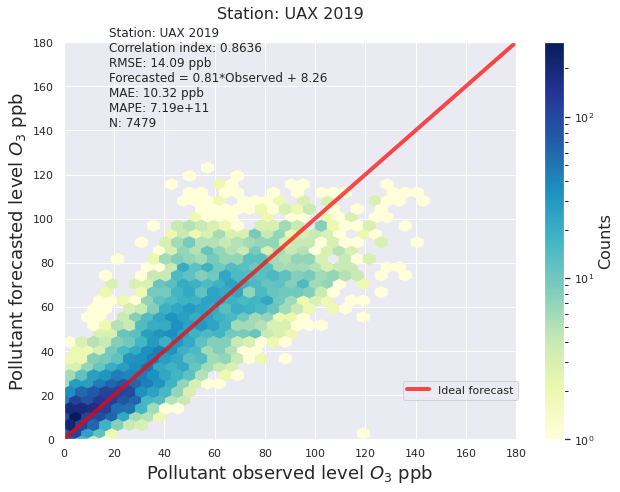

In [25]:
# TODO: traducir estos plots pasandole los Labels en Español
# %% Evaluating only a set of stations and hours
for station in evaluate_stations:
    for hour in evaluate_hours:
        cur_column = f'plus_{hour:02}_cont_otres_{station}'
        print(f'column name:{cur_column}')
        # analyze_column(cur_column)
        analyze_column(cur_column,
                       y_pred_descaled_df,
                       y_true_df,
                       test_year=test_year,
                       output_results_folder_img=output_results_folder_img)

# Visualize evolution of n_hours forecasted
#for station in evaluate_stations:
#    analyze_multi_hour_plot(
#        station,
#       evaluate_hours,
#        y_pred_descaled_df,
#        y_true_df,
#        test_year=test_year,
#       output_results_folder_img=output_results_folder_img)


In [26]:
# %% #Create DataFrame with metric results 

results_df = pd.DataFrame(columns=[
    "Columna", "Índice de correlación", "MAE", "MAPE", "MSE", "RMSE", "R2","Index of agreement"
])

for cur_column in y_pred_descaled_df.columns:
    #print(cur_column)
    column_results = analyze_column(cur_column,
                                    y_pred_descaled_df,
                                    y_true_df,
                                    test_year=test_year,
                                    generate_plot=False)
    results_df = results_df.append(column_results, ignore_index=True)




Correlation index:                     0.9362
Correlation index:                     0.8932
Correlation index:                     0.9282
Correlation index:                     0.8837
Correlation index:                     0.9043
Correlation index:                     0.9355
Correlation index:                     0.9398
Correlation index:                     0.9400
Correlation index:                     0.9195
Correlation index:                     0.9313
Correlation index:                     0.9461
Correlation index:                     0.9378
Correlation index:                     0.9437
Correlation index:                     0.9038
Correlation index:                     0.9351
Correlation index:                     0.9443
Correlation index:                     0.9328
Correlation index:                     0.9399
Correlation index:                     0.9479
Correlation index:                     0.9250
Correlation index:                     0.9357
Correlation index:                

In [27]:
# Extract unique station identifiers from the "Columna" column
station_identifiers = results_df['Columna'].str.split('_').str[4].unique()
station_identifiers

array(['UIZ', 'AJU', 'ATI', 'CUA', 'SFE', 'SAG', 'CUT', 'PED', 'TAH',
       'GAM', 'IZT', 'CCA', 'HGM', 'LPR', 'MGH', 'CAM', 'FAC', 'TLA',
       'MER', 'XAL', 'LLA', 'TLI', 'UAX', 'BJU', 'MPA', 'MON', 'NEZ',
       'INN', 'AJM', 'VIF'], dtype=object)

In [28]:
results_df.rename(columns={'Índice de correlación': 'Correlation Index'}, inplace=True)


In [29]:
results_df

Columna  Correlation Index        MAE          MAPE  \
0    plus_01_cont_otres_UIZ           0.936156   7.118227  2.976779e+14   
1    plus_01_cont_otres_AJU           0.893209  11.612323  2.873532e+14   
2    plus_01_cont_otres_ATI           0.928181   7.391601  1.003184e+15   
3    plus_01_cont_otres_CUA           0.883675   8.394414  3.908166e-01   
4    plus_01_cont_otres_SFE           0.904346   8.120199  1.434481e+14   
..                      ...                ...        ...           ...   
715  plus_24_cont_otres_MON           0.890021   9.995342  6.066160e+12   
716  plus_24_cont_otres_NEZ           0.886378  10.266807  9.246081e+12   
717  plus_24_cont_otres_INN           0.778344  10.772329  4.597497e-01   
718  plus_24_cont_otres_AJM           0.811592  11.239305  6.257708e-01   
719  plus_24_cont_otres_VIF           0.875941   8.352417  6.331904e-01   

            MSE       RMSE        R2  Index of agreement  
0     89.398051   9.455054  0.868104            0.960310  
1    222.984055  14.932651  0.673850            0.857260  
2     91.249598   9.552466  0.828155            0.956939  
3    120.091363  10.958620  0.771604            0.935130  
4    111.815082  10.574265  0.799840            0.945033  
..          ...        ...       ...                 ...  
715  153.231393  12.378667  0.778858            0.926966  
716  186.022384  13.639002  0.754519            0.916757  
717  179.691898  13.404921  0.575893            0.827604  
718  205.260524  14.326916  0.630920            0.878210  
719  117.888613  10.857652  0.761329            0.922356  

[720 rows x 8 columns]

## <a id="Scatter_Metrics_for_Model_Outputs">Gráficos de Dispersión para las Métricas de Salidas del Modelo</a>
### MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Plots index return](#Plots_index)

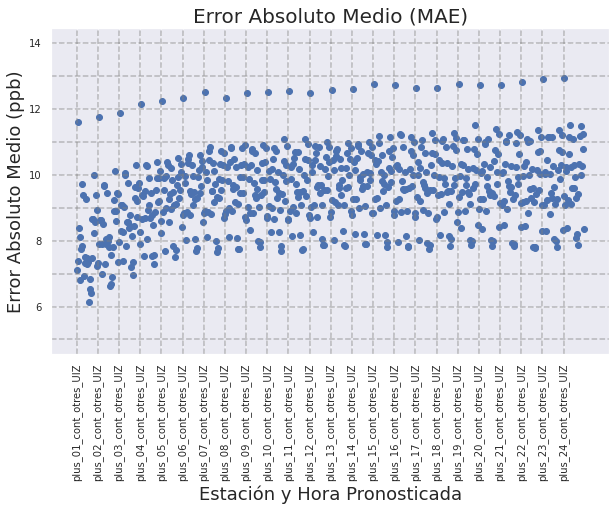

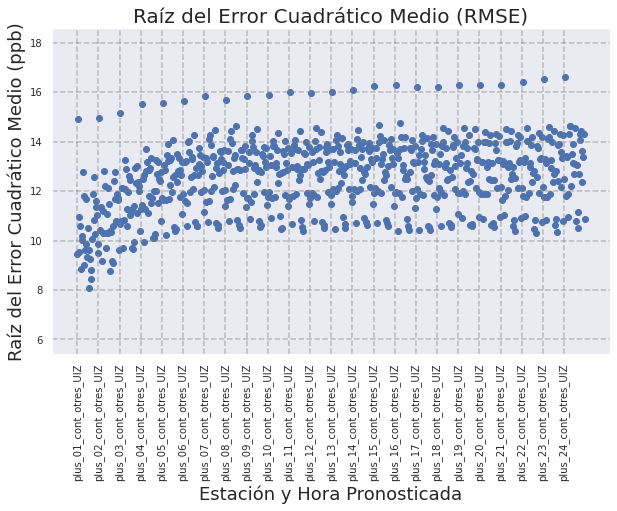

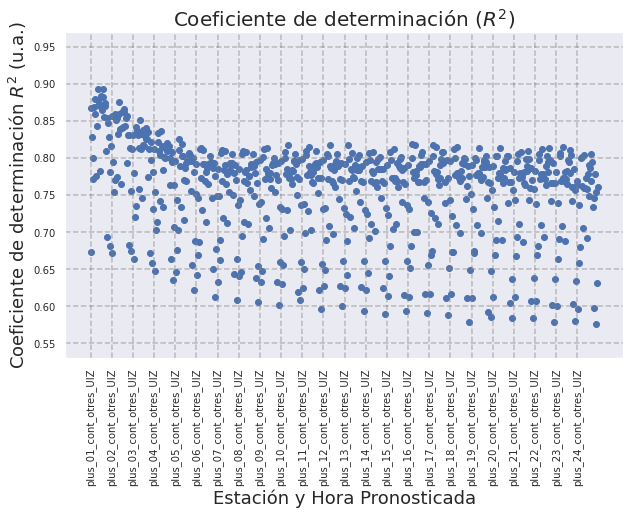

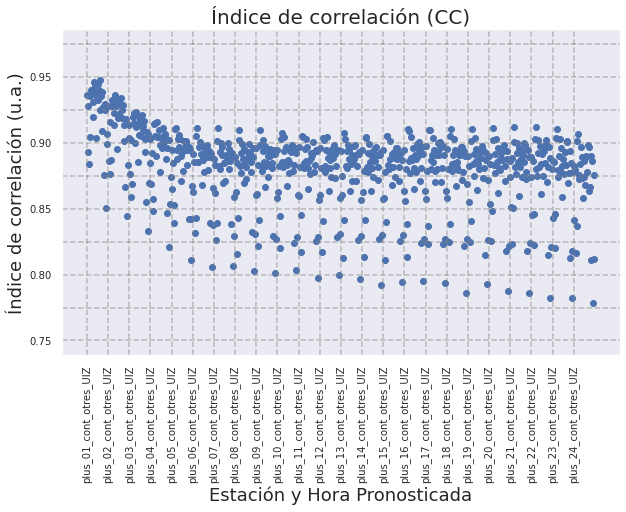

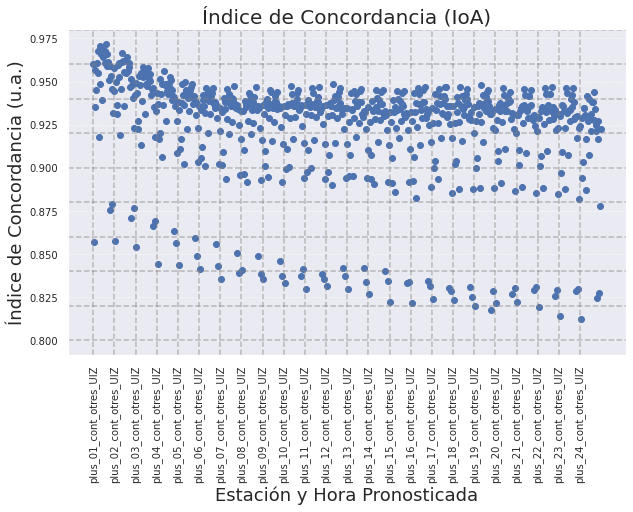

In [30]:
from os.path import join
import matplotlib.pyplot as plt

def scatter_plot_by_column(df, metric, output_folder=None, 
                           show_grid=True, x_label='Station and forecasted hours', 
                           y_label=None, title_str=True, save_fig=True,
                           x_label_fontsize=18, y_label_fontsize=18, 
                           title_fontsize=20, tick_fontsize=14):
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[metric])
    
    plt.xlabel(x_label, fontsize=x_label_fontsize)
    plt.ylabel(y_label if y_label else metric, fontsize=y_label_fontsize)
    
    if title_str:
        pass
        #title_str = f'{metric}'
    else:
        title_str = ''
        
    plt.title(title_str, fontsize=title_fontsize)
    
    x_ticks = df.index[::30]
    x_labels = df['Columna'][::30]
    plt.xticks(x_ticks, x_labels, rotation=90, fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    if show_grid:
        for x in x_ticks:
            plt.axvline(x, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='x', linestyle='dashed', alpha=0.5)
        
        y_ticks = plt.gca().get_yticks()
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)
    
    if save_fig and output_folder:
        plt.savefig(join(output_folder, f'scatter_plot_{metric.lower()}.png'), dpi=300)
        
    plt.show()
# Para MAE
scatter_plot_by_column(results_df, 'MAE',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Estación y Hora Pronosticada',
                y_label='Error Absoluto Medio (ppb)',
                title_str='Error Absoluto Medio (MAE)',
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)

# Para RMSE
scatter_plot_by_column(results_df, 'RMSE',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Estación y Hora Pronosticada',
                y_label='Raíz del Error Cuadrático Medio (ppb)',
                title_str='Raíz del Error Cuadrático Medio (RMSE)',
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)

# Para R2
scatter_plot_by_column(results_df, 'R2',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Estación y Hora Pronosticada',
                y_label='Coeficiente de determinación $R^2$ (u.a.)', 
                title_str='Coeficiente de determinación ($R^2$)',
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)
# CC
scatter_plot_by_column(results_df, 'Correlation Index',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Estación y Hora Pronosticada', 
                y_label='Índice de correlación (u.a.)', 
                title_str='Índice de correlación (CC)', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)


# IoA
scatter_plot_by_column(results_df, 'Index of agreement',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Estación y Hora Pronosticada',
                y_label='Índice de Concordancia (u.a.)', 
                title_str='Índice de Concordancia (IoA)', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)

## <a id="Bar_Charts_Averaging_Metrics_over_Stations">Gráficos de Barras Métricas Sobre Estaciones</a>
### MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Return to Plots Index](#Plots_index) 

Per station MAE: 9.5403


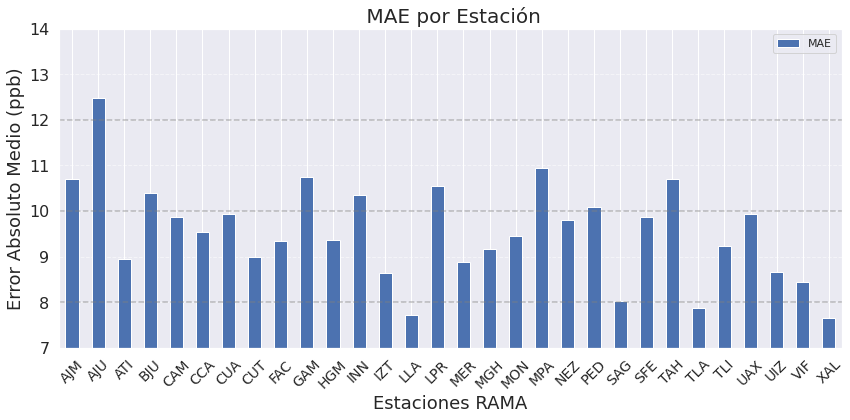

Per station RMSE: 12.5676


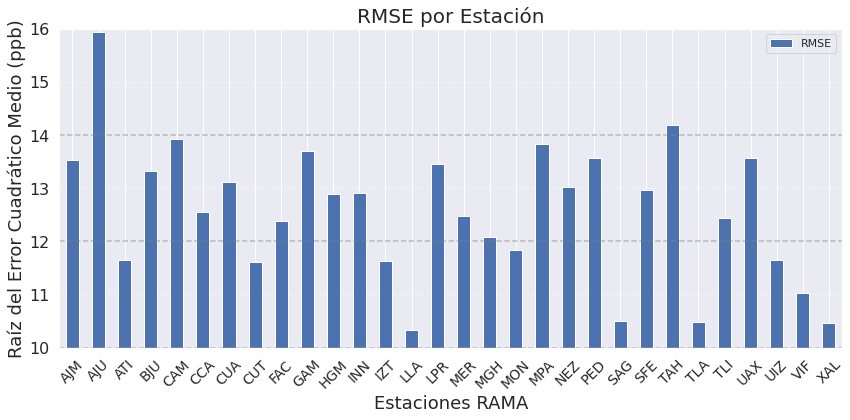

Per station R2: 0.7568


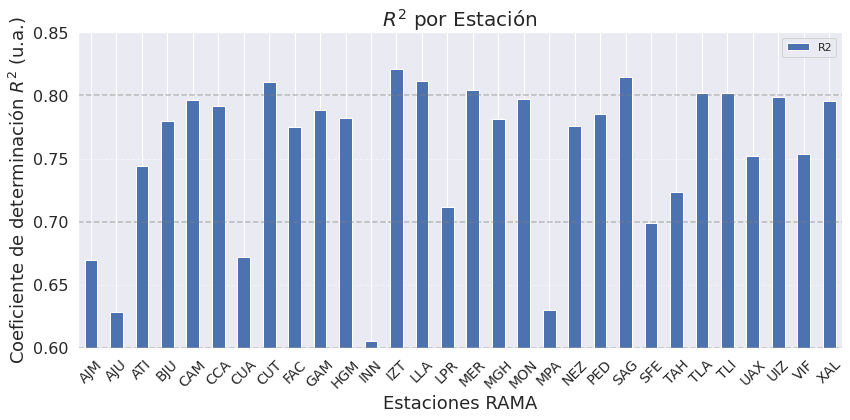

Per station Correlation Index: 0.8809


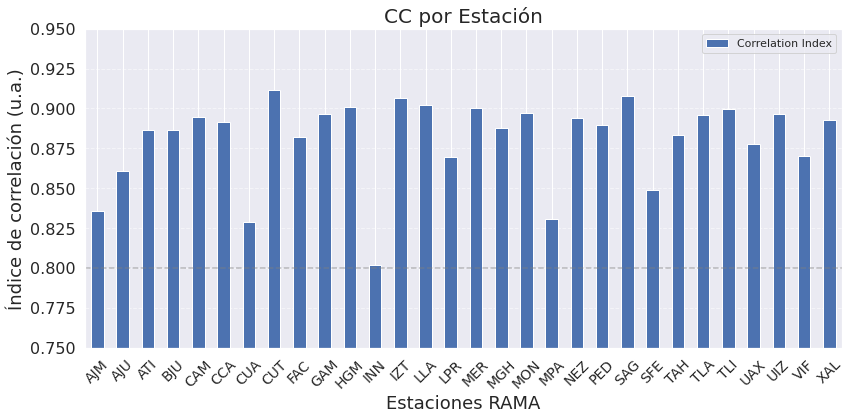

Per station Index of agreement: 0.9223


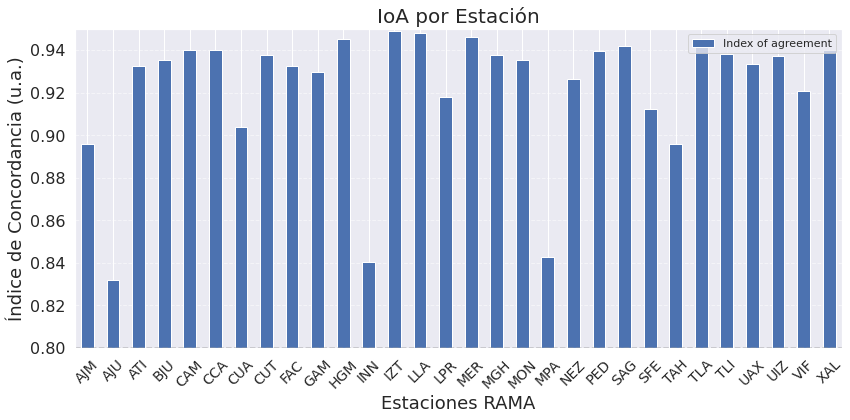

In [31]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

def average_metric(results_df, metric, output_results_folder_img=None, 
                    show_grid=True, x_label='Station', y_label=None, 
                    title_suffix='', save_fig=True, title_str=True,
                    subtitle=True, y_limit=None):  # Agregar el nuevo parámetro aquí
    """
    Generate a bar plot for average metrics.
    
    Parameters:
    ...
    y_limit: tuple, optional
        A tuple (min, max) to set the y-axis limits.
    """
# def average_metric(results_df, metric, output_results_folder_img=None, 
#                     show_grid=True, x_label='Station', y_label=None, 
#                     title_suffix='', save_fig=True, title_str=True,
#                     subtitle=True):
#     """
#     Generate a bar plot for average metrics.
    
#     Parameters:
#     ...
#     """

    # Helper function to calculate average metrics
    def calculate_average_metrics(df, key):
        return df[df['Columna'].str.endswith(key)][metric].mean()

    station_keys = sorted(set(results_df['Columna'].apply(lambda x: x.split('_')[-1])))
    average_metrics = [calculate_average_metrics(results_df, key) for key in station_keys]
    
    # Create DataFrame
    average_metrics_df = pd.DataFrame({x_label: station_keys, metric: average_metrics})

    # Overall Average
    overall_average_metric = average_metrics_df[metric].mean()
    print(f"Per station {metric}: {overall_average_metric:.4f}")

    # Plotting
    ax = average_metrics_df.plot(x=x_label, y=metric, kind='bar', figsize=(12, 6))

    # Title Handling
    if isinstance(title_str, str):
        pass
    elif title_str:
        title_str = f'{title_suffix}'
    else:
        title_str = ''
    
    if subtitle:
        title_str += f"\n Overall stations {metric} {overall_average_metric:.4f}"
    
    ax.set_title(title_str, fontsize=20)
    ax.set_ylabel(y_label if y_label else metric, fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    
    if show_grid:
        y_ticks = plt.gca().get_yticks()  # Obtener los ticks del eje y
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)  # Agregar grid en el eje y
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)

    if y_limit:  # Aplicar los límites del eje Y si se proporcionan
        ax.set_ylim(y_limit)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'avg_metric_plot_{metric.lower()}.png'), dpi=300)
    
    plt.show()

average_metric(results_df, 'MAE', output_results_folder_img, show_grid=True, 
               x_label='Estaciones RAMA', y_label='Error Absoluto Medio (ppb)', 
               title_str=True, title_suffix=' MAE por Estación', save_fig=True, 
               subtitle=False, y_limit=(7, 14))

# RMSE con límites entre 10 y 16
average_metric(results_df, 'RMSE', output_results_folder_img, show_grid=True, 
               x_label='Estaciones RAMA', y_label='Raíz del Error Cuadrático Medio (ppb)', 
               title_str=True, title_suffix='RMSE por Estación', save_fig=True, 
               subtitle=False, y_limit=(10, 16))

# R2 
average_metric(results_df, 'R2', output_results_folder_img, show_grid=True, 
               x_label='Estaciones RAMA', y_label='Coeficiente de determinación $R^2$ (u.a.)', 
               title_str=True, title_suffix='$R^2$ por Estación', save_fig=True, 
               subtitle=False, y_limit=(0.6, 0.85))

# Correlation Index 
average_metric(results_df, 'Correlation Index', output_results_folder_img, show_grid=True, 
               x_label='Estaciones RAMA', y_label='Índice de correlación (u.a.)', 
               title_str=True, title_suffix='CC por Estación', save_fig=True, 
               subtitle=False, y_limit=(0.75, 0.95))

# Index of Agreement con límites entre 0.8 y 0.95
average_metric(results_df, 'Index of agreement', output_results_folder_img, show_grid=True, 
               x_label='Estaciones RAMA', y_label='Índice de Concordancia (u.a.)', 
               title_str=True, title_suffix='IoA por Estación', save_fig=True, 
               subtitle=False, y_limit=(0.8, 0.95))

#average_metric(results_df, 'MAE', output_results_folder_img, show_grid=True, x_label='Estaciones RAMA', y_label='Error Absoluto Medio (ppb)', title_str=True, title_suffix=' MAE por Estación', save_fig=True, subtitle=False)
#average_metric(results_df, 'RMSE', output_results_folder_img, show_grid=True, x_label='Estaciones RAMA', y_label='Raíz del Error Cuadrático Medio (ppb)', title_str=True, title_suffix='RMSE por Estación', save_fig=True, subtitle=False)
#average_metric(results_df, 'R2', output_results_folder_img, show_grid=True, x_label='Estaciones RAMA', y_label='Coeficiente de determinación $R^2$ (u.a.)', title_str=True, title_suffix='$R^2$ por Estación', save_fig=True, subtitle=False)
#average_metric(results_df, 'Correlation Index', output_results_folder_img, show_grid=True, x_label='Estaciones RAMA', y_label='Índice de correlación (u.a.)', title_str=True, title_suffix='CC por Estación', save_fig=True, subtitle=False)
#average_metric(results_df, 'Index of agreement', output_results_folder_img, show_grid=True, x_label='Estaciones RAMA', y_label='Índice de Concordancia (u.a.)', title_str=True, title_suffix='IoA por Estación', save_fig=True, subtitle=False)

## <a id="Bar_Charts_Averaging_Metrics_over_Hours">Gráficos de Barras Sobre Horas Pronosticadas</a>
### MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Return to Plots Index](#Plots_index)  

Overall average of MAE across all hours: 9.5403


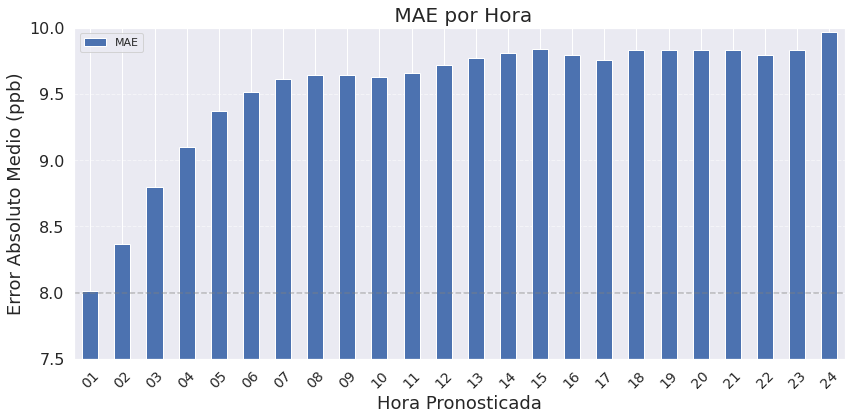

Overall average of RMSE across all hours: 12.5676


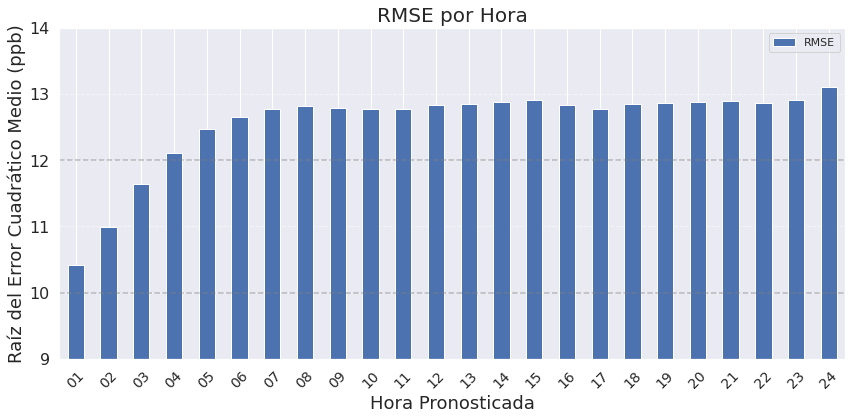

Overall average of R2 across all hours: 0.7568


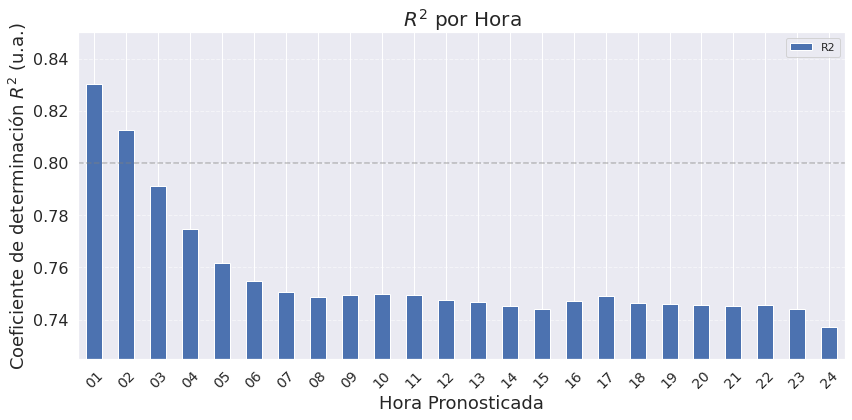

Overall average of Correlation Index across all hours: 0.8809


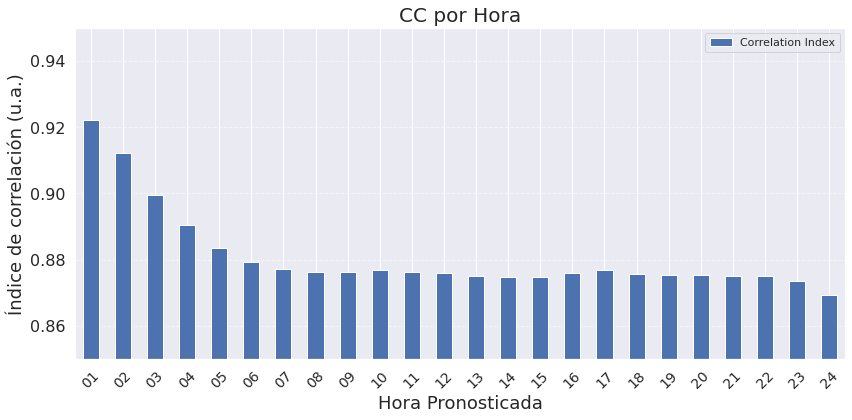

Overall average of Index of agreement across all hours: 0.9223


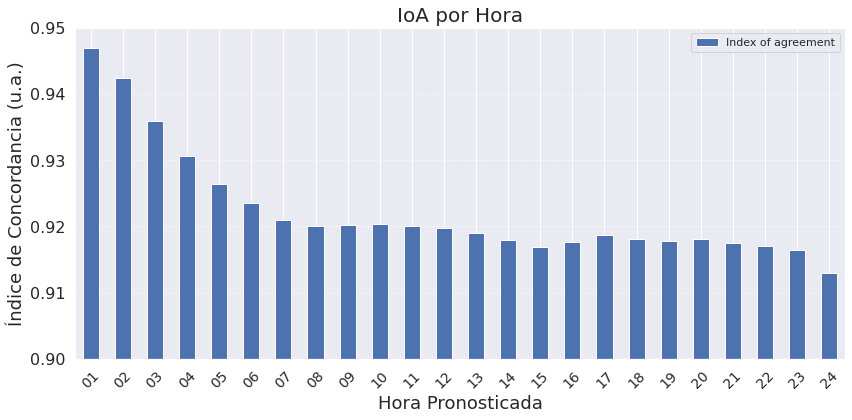

In [32]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

def average_metric_by_hour(results_df, metric, output_results_folder_img=None, 
                           show_grid=True, x_label='Forecasted Hour', y_label=None, 
                           title_suffix='', save_fig=True, title_str=True, 
                           subtitle=True, y_limit=None):
    """
    Generate a bar plot for average metrics by hour.
    
    Parameters:
    ...
    """

    # Helper function to calculate average metrics by hour
    def calculate_average_metrics_by_hour(df, key):
        return df[df['Columna'].str.contains(key)][metric].mean()

    hour_keys = sorted(set(results_df['Columna'].apply(lambda x: x.split('_')[1])), 
                       key=lambda x: int(x.split('plus_')[-1]))
    average_metrics = [calculate_average_metrics_by_hour(results_df, key) for key in hour_keys]
    
    # Create DataFrame
    average_metrics_df = pd.DataFrame({x_label: hour_keys, metric: average_metrics})

    # Overall Average
    overall_average_metric = average_metrics_df[metric].mean()
    print(f"Overall average of {metric} across all hours: {overall_average_metric:.4f}")

    # Plotting
    ax = average_metrics_df.plot(x=x_label, y=metric, kind='bar', figsize=(12, 6))

    # Title Handling
    if isinstance(title_str, str):
        pass
    elif title_str:
        title_str = f'{title_suffix}'
    else:
        title_str = ''
    
    if subtitle:
        title_str += f"\n Overall average of {metric} across all hours: {overall_average_metric:.4f}"
    
    ax.set_title(title_str, fontsize=20)
    ax.set_ylabel(y_label if y_label else metric, fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    
    if show_grid:
        y_ticks = plt.gca().get_yticks()
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)
    
    if y_limit:  
        ax.set_ylim(y_limit)
        
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'avg_hours_plot_{metric.lower()}.png'), dpi=300)
    
    plt.show()


# %% Llamada a función para graficar las métricas de resumen de todas las estaciones por hora
average_metric_by_hour(results_df, 'MAE', output_results_folder_img, show_grid=True, 
               x_label='Hora Pronosticada', y_label='Error Absoluto Medio (ppb)', 
               title_str=True, title_suffix=' MAE por Hora', save_fig=True, 
               subtitle=False, y_limit=(7.5, 10))

# RMSE 
average_metric_by_hour(results_df, 'RMSE', output_results_folder_img, show_grid=True, 
               x_label='Hora Pronosticada', y_label='Raíz del Error Cuadrático Medio (ppb)', 
               title_str=True, title_suffix='RMSE por Hora', save_fig=True, 
               subtitle=False, y_limit=(9, 14))

# R2 
average_metric_by_hour(results_df, 'R2', output_results_folder_img, show_grid=True, 
               x_label='Hora Pronosticada', y_label='Coeficiente de determinación $R^2$ (u.a.)', 
               title_str=True, title_suffix='$R^2$ por Hora', save_fig=True, 
               subtitle=False, y_limit=(0.725, 0.85))

# Correlation Index 
average_metric_by_hour(results_df, 'Correlation Index', output_results_folder_img, show_grid=True, 
               x_label='Hora Pronosticada', y_label='Índice de correlación (u.a.)', 
               title_str=True, title_suffix='CC por Hora', save_fig=True, 
               subtitle=False, y_limit=(0.85, 0.95))

# Index of Agreement 
average_metric_by_hour(results_df, 'Index of agreement', output_results_folder_img, show_grid=True, 
               x_label='Hora Pronosticada', y_label='Índice de Concordancia (u.a.)', 
               title_str=True, title_suffix='IoA por Hora', save_fig=True, 
               subtitle=False, y_limit=(0.9, 0.95))

24h Errors

plus_01_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 4.998422144227109
Desviación estándar de diferencia en valores máximos diarios: 12.42738826684824


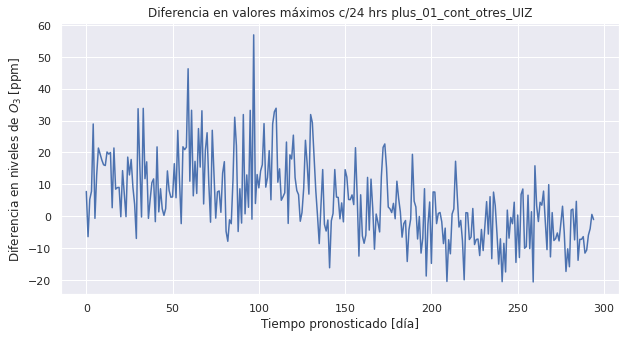

plus_06_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 4.501271503254519
Desviación estándar de diferencia en valores máximos diarios: 17.058492970969926


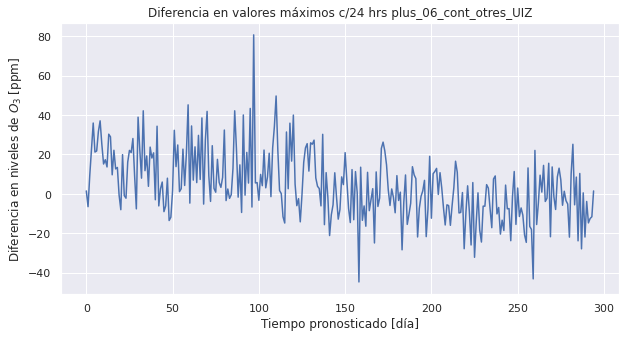

plus_12_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 7.398984526312072
Desviación estándar de diferencia en valores máximos diarios: 15.778194264323178


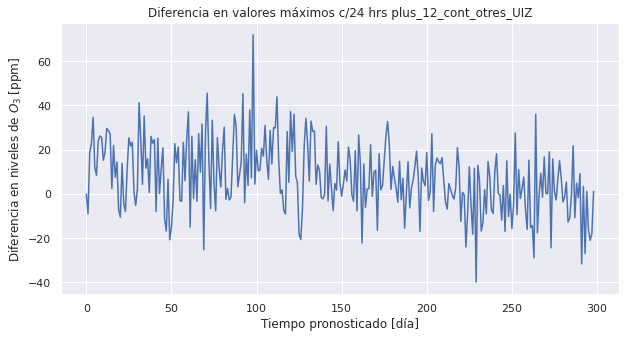

plus_18_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 7.192483982524356
Desviación estándar de diferencia en valores máximos diarios: 16.85538015229221


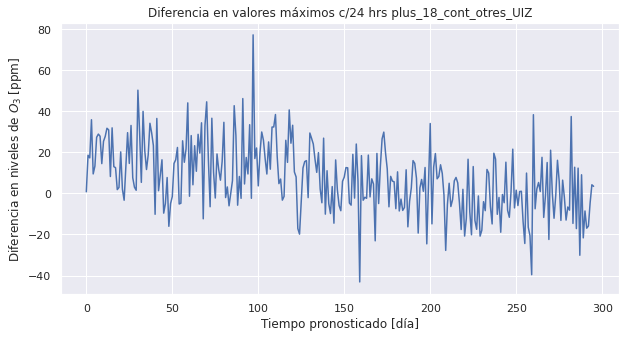

plus_24_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 8.10032563469037
Desviación estándar de diferencia en valores máximos diarios: 17.842632761683543


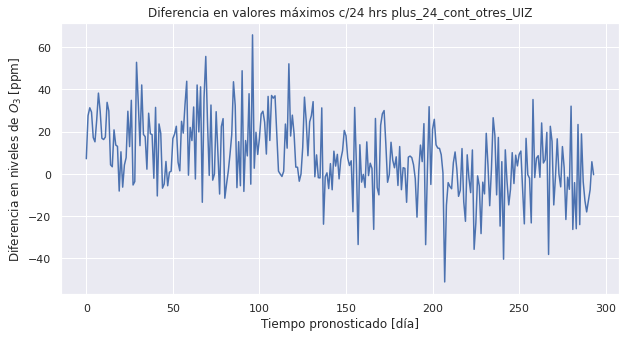

plus_01_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 17.586409340077395
Desviación estándar de diferencia en valores máximos diarios: 18.23452213721007


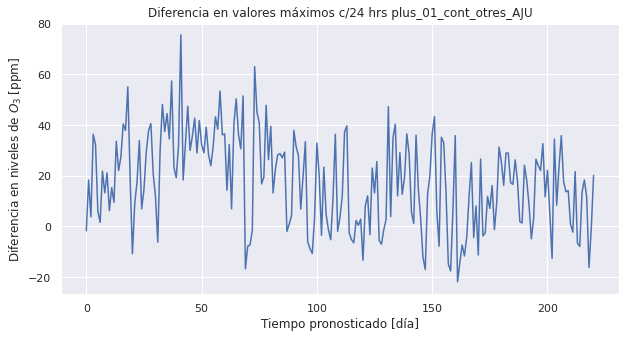

plus_06_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 17.268779479705536
Desviación estándar de diferencia en valores máximos diarios: 19.816406324176942


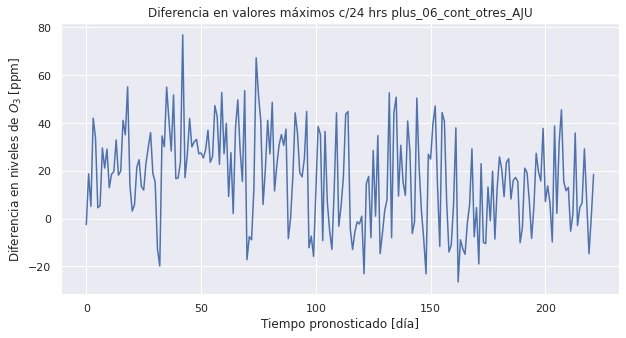

plus_12_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 19.61732495797647
Desviación estándar de diferencia en valores máximos diarios: 19.052380683108723


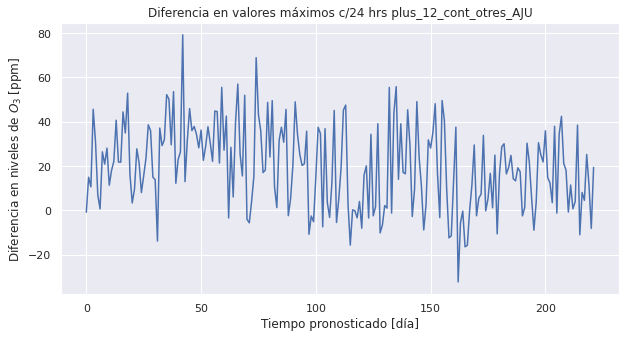

plus_18_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 20.05894964430067
Desviación estándar de diferencia en valores máximos diarios: 20.09875769826661


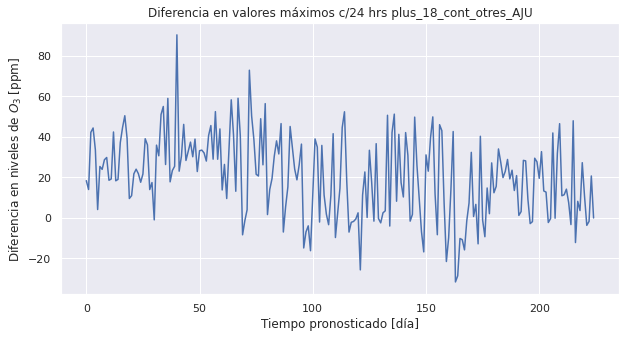

plus_24_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 18.786757011936135
Desviación estándar de diferencia en valores máximos diarios: 21.35682668352127


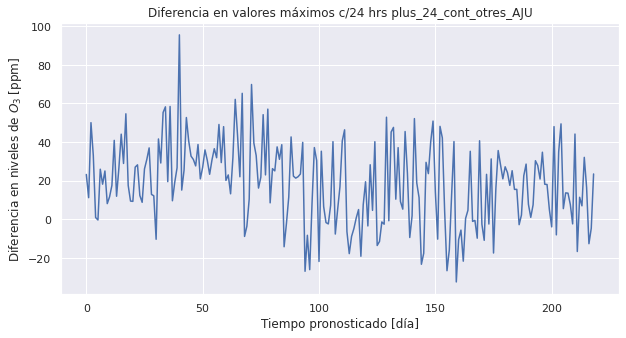

plus_01_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -5.129151033632683
Desviación estándar de diferencia en valores máximos diarios: 11.109957142069682


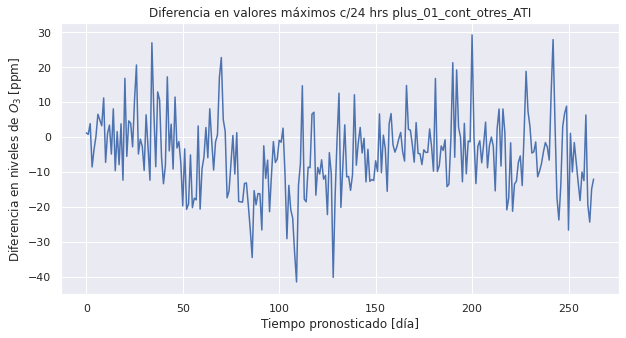

plus_06_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -4.700210137474806
Desviación estándar de diferencia en valores máximos diarios: 15.51406774336254


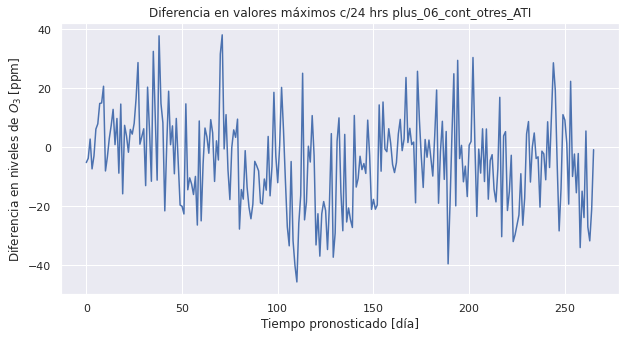

plus_12_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -3.320799583779242
Desviación estándar de diferencia en valores máximos diarios: 15.121605542026291


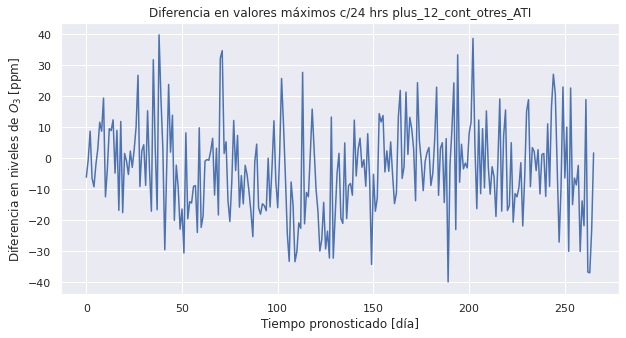

plus_18_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -3.8999148242878463
Desviación estándar de diferencia en valores máximos diarios: 14.736732184703273


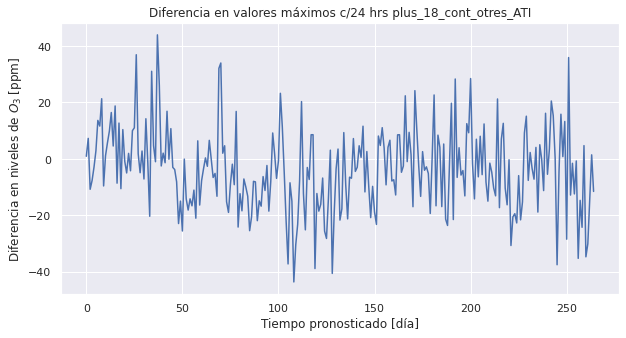

plus_24_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -3.532945388218142
Desviación estándar de diferencia en valores máximos diarios: 16.2954444506172


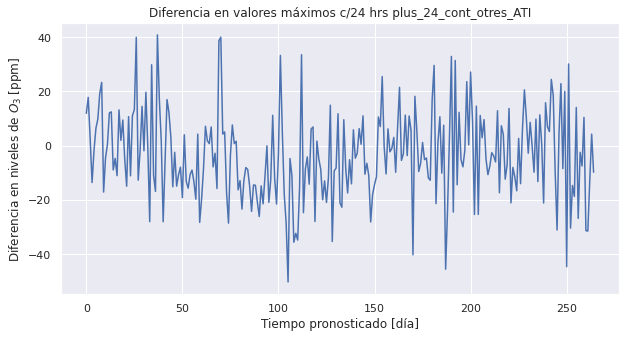

plus_01_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -2.5983590592851153
Desviación estándar de diferencia en valores máximos diarios: 18.160769440360454


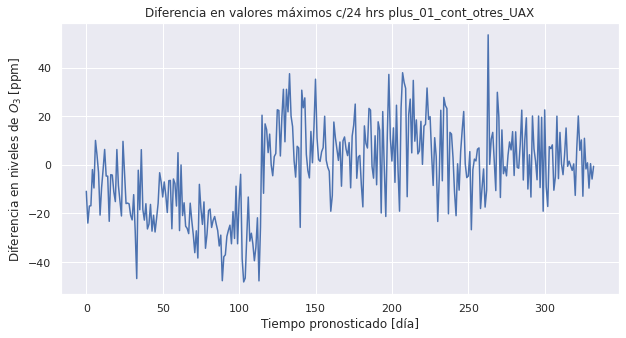

plus_06_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -2.944819872964642
Desviación estándar de diferencia en valores máximos diarios: 22.235302268412944


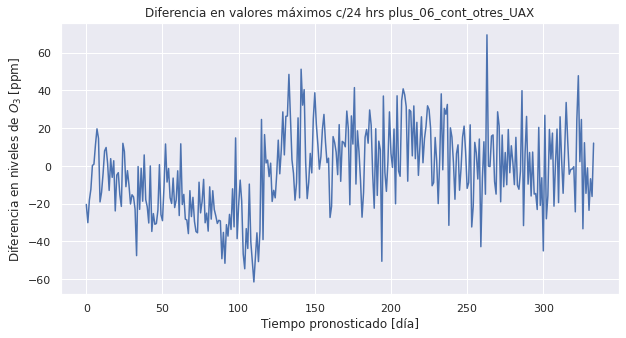

plus_12_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 1.3117428393591017
Desviación estándar de diferencia en valores máximos diarios: 21.452149862477473


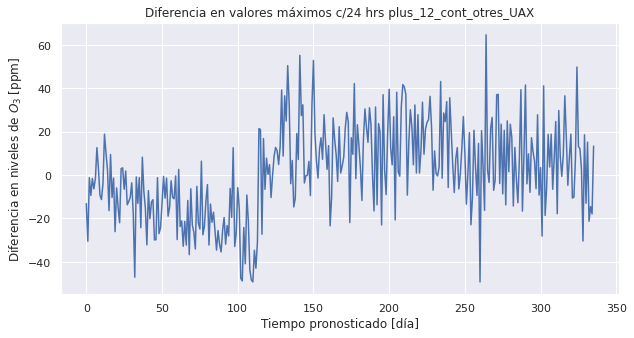

plus_18_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -0.42040453186954363
Desviación estándar de diferencia en valores máximos diarios: 21.323003802491982


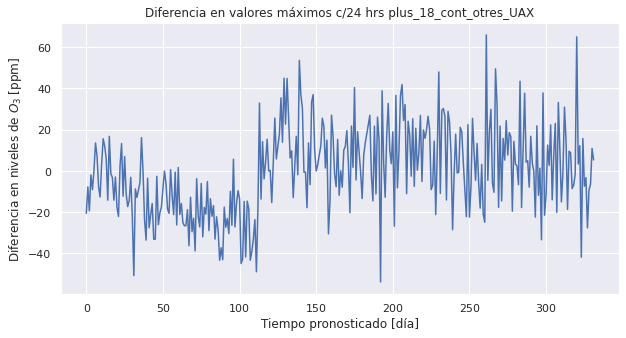

plus_24_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 0.9515719903559843
Desviación estándar de diferencia en valores máximos diarios: 22.76848230452815


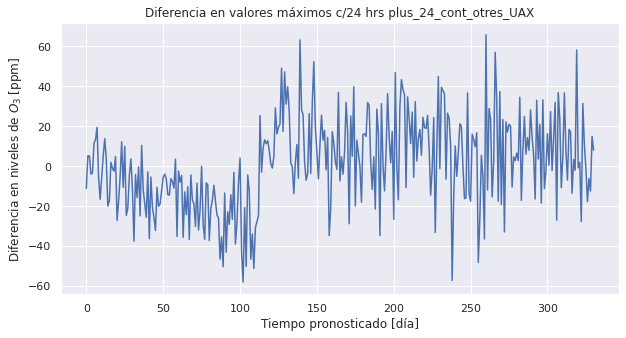

Promedio de h24_max_err_mean: 5.061320931160385
Promedio de h24_max_err_std: 17.861924834172537


In [33]:
# %% Calculo de valores máximos por cada 24 horas. 
# Crear un DataFrame vacío
# TODO, poner opcion para bloquear el graficado.
results_max_df = pd.DataFrame(columns=[
    'max_y_true', 'max_y_pred', 'h24_max_err_mean', 'h24_max_err_std'
])

# Rellenar el DataFrame con los resultados de la función
for cur_column in params_grid:
    print(cur_column)
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std = plot_max_difference(
        cur_column, y_true_df, y_pred_descaled_df)
    results_max_df = results_max_df.append(
        {
            'max_y_true': max_y_true,
            'max_y_pred': max_y_pred,
            'h24_max_err_mean': h24_max_err_mean,
            'h24_max_err_std': h24_max_err_std
        },
        ignore_index=True)

# Calcular el promedio de las cuatro columnas
average_h24_max_err_mean = results_max_df['h24_max_err_mean'].mean()
average_h24_max_err_std = results_max_df['h24_max_err_std'].mean()

print("Promedio de h24_max_err_mean:", average_h24_max_err_mean)
print("Promedio de h24_max_err_std:", average_h24_max_err_std)


In [34]:
# Inicializar nuevas columnas para almacenar los resultados adicionales
results_df['h24_max_err_mean'] = 0.0
results_df['h24_max_err_std'] = 0.0
results_df['h24_mean_err_mean'] = 0.0
results_df['h24_mean_err_std'] = 0.0
errors_dict = {}

# Iterar a través de cada fila en el DataFrame para actualizar las nuevas columnas
for index, row in results_df.iterrows():
    cur_column = row['Columna']
    # Llamar a la función plot_max_and_mean_difference y obtener los resultados
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std, mean_y_true, mean_y_pred, h24_mean_err_mean, h24_mean_err_std = plot_max_and_mean_difference(cur_column, y_true_df, y_pred_descaled_df)
    
    # Actualizar las nuevas columnas con los resultados obtenidos
    results_df.loc[index, 'h24_max_err_mean'] = h24_max_err_mean
    results_df.loc[index, 'h24_max_err_std'] = h24_max_err_std
    results_df.loc[index, 'h24_mean_err_mean'] = h24_mean_err_mean
    results_df.loc[index, 'h24_mean_err_std'] = h24_mean_err_std
    # Almacenar max_y_true, max_y_pred, mean_y_true, y mean_y_pred en el diccionario errors_dict
    errors_dict[cur_column] = {
        'max_y_true': max_y_true,
        'max_y_pred': max_y_pred,
        'mean_y_true': mean_y_true,
        'mean_y_pred': mean_y_pred
    }

plus_01_cont_otres_UIZ
Maximum error mean over 24 hrs: 4.998422144227109
Maximum error std dev over 24 hrs: 12.42738826684824
Mean error mean over 24 hrs: 0.596750082707001
Mean error std dev over 24 hrs: 4.389974561507988
plus_01_cont_otres_AJU
Maximum error mean over 24 hrs: 17.586409340077395
Maximum error std dev over 24 hrs: 18.23452213721007
Mean error mean over 24 hrs: 0.9374238187011734
Mean error std dev over 24 hrs: 6.171589247891838
plus_01_cont_otres_ATI
Maximum error mean over 24 hrs: -5.129151033632683
Maximum error std dev over 24 hrs: 11.109957142069682
Mean error mean over 24 hrs: -3.441873440838824
Mean error std dev over 24 hrs: 3.4410890561963345
plus_01_cont_otres_CUA
Maximum error mean over 24 hrs: 2.37944405635427
Maximum error std dev over 24 hrs: 16.107889898101625
Mean error mean over 24 hrs: 1.9094459018835535
Mean error std dev over 24 hrs: 5.1410317375349885
plus_01_cont_otres_SFE
Maximum error mean over 24 hrs: -2.791813711632885
Maximum error std dev over

## <a id="Scatter_Plots_of_24h_Error_Graphics">Scatter Plots of 24h Error Eval</a>
### Max, Average
- [Return to Plots Index](#Plots_index)  

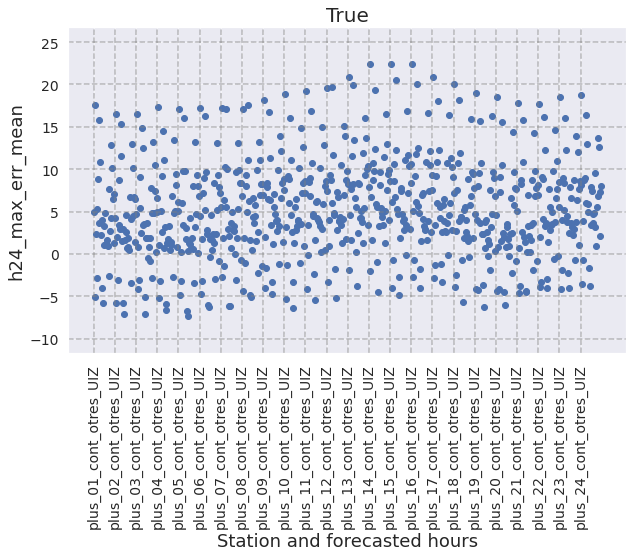

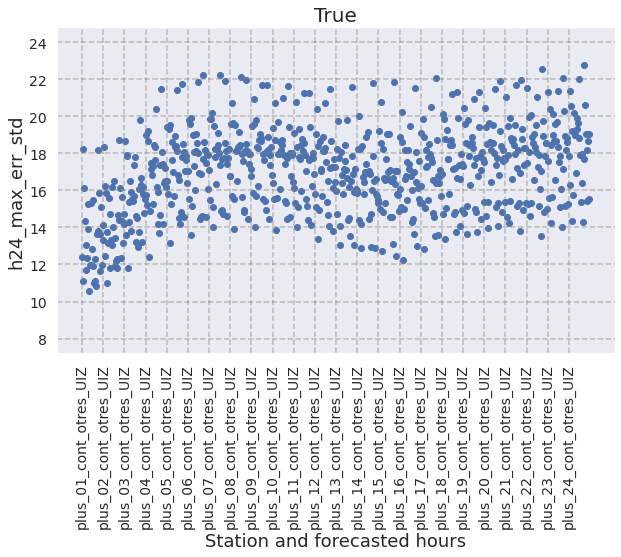

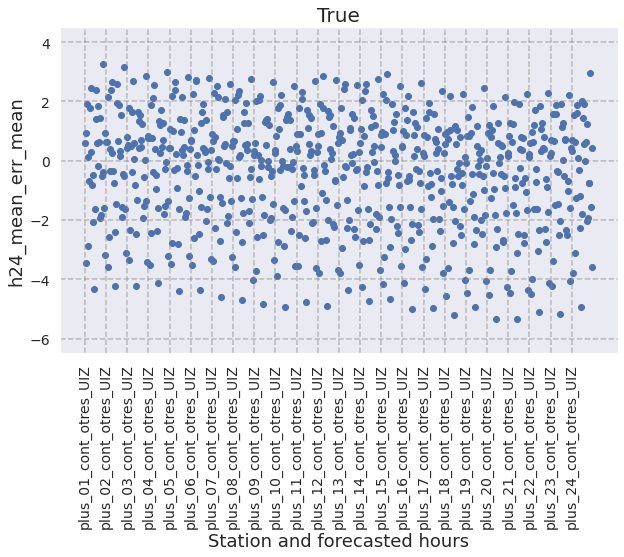

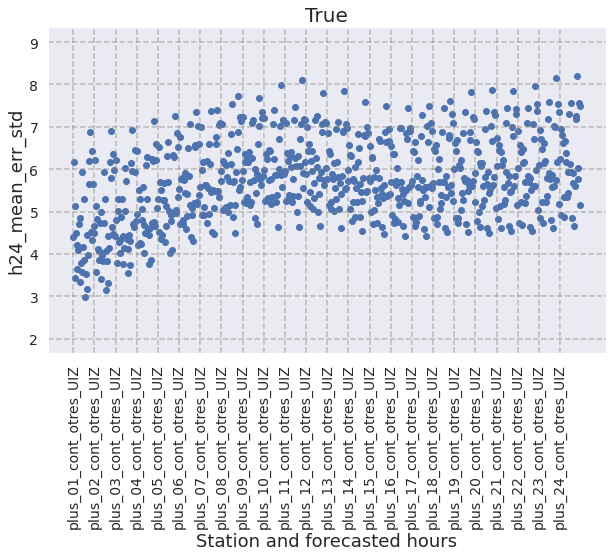

In [35]:
scatter_plot_by_column(results_df, 'h24_max_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_max_err_std',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_std',
                output_results_folder_img)

## <a id="Bar_Charts_of_24h_Errors_over_Stations">Bar Charts of 24h Errors over Stations</a>
### Max, Average
- [Return to Plots Index](#Plots_index)  

Per station h24_max_err_mean: 5.2093


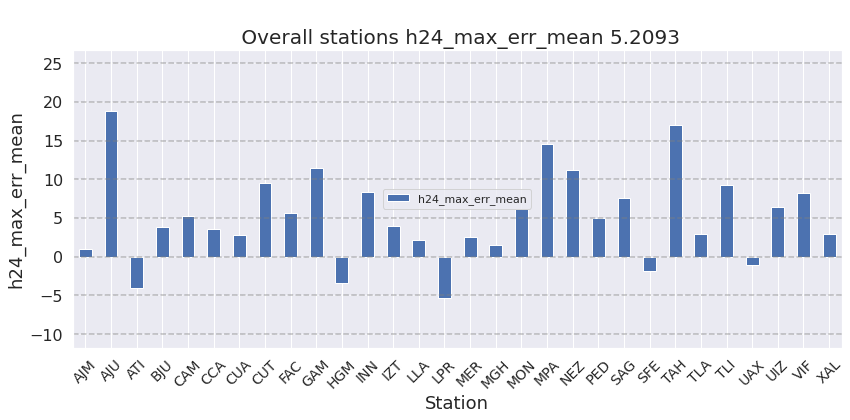

Per station h24_max_err_std: 16.9803


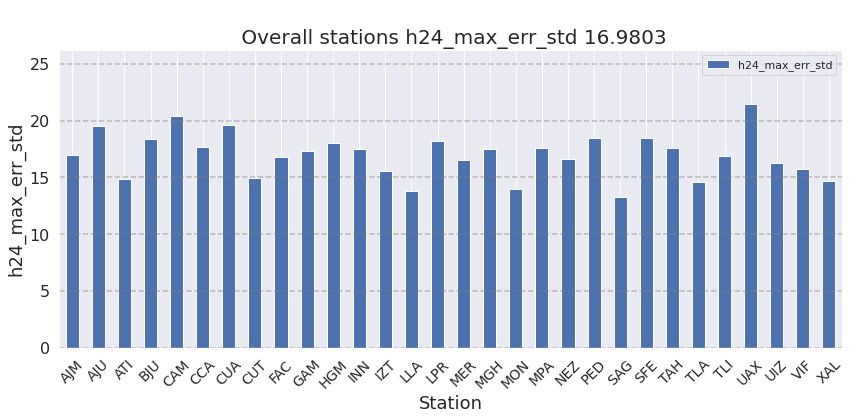

Per station h24_mean_err_mean: -0.4149


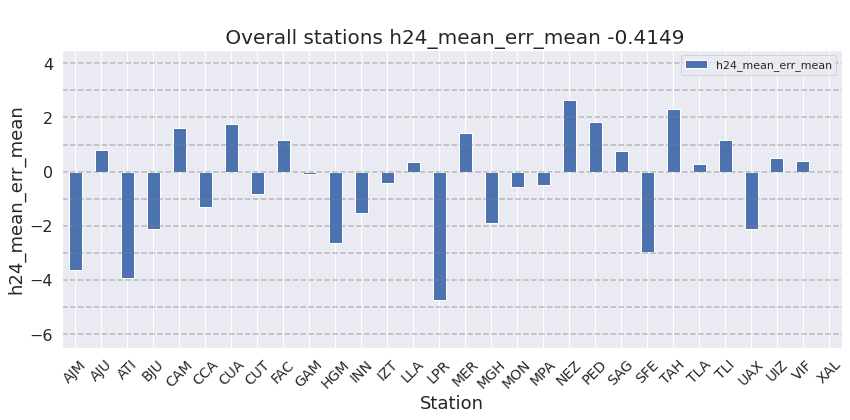

Per station h24_mean_err_std: 5.7490


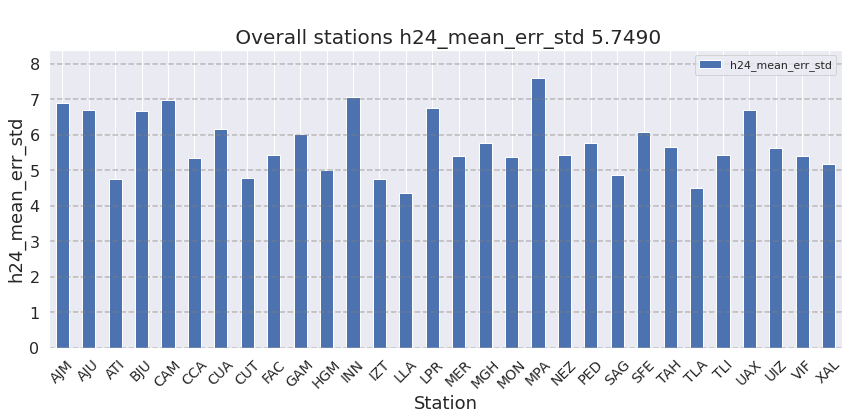

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Tu código aquí callando warnings
    average_metric(results_df, 'h24_max_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_max_err_std', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_std', output_results_folder_img)

## <a id="Results_df_Table">Results_df Table</a>
- [Return to Plots Index](#Plots_index)  

In [37]:
results_df

Columna  Correlation Index        MAE          MAPE  \
0    plus_01_cont_otres_UIZ           0.936156   7.118227  2.976779e+14   
1    plus_01_cont_otres_AJU           0.893209  11.612323  2.873532e+14   
2    plus_01_cont_otres_ATI           0.928181   7.391601  1.003184e+15   
3    plus_01_cont_otres_CUA           0.883675   8.394414  3.908166e-01   
4    plus_01_cont_otres_SFE           0.904346   8.120199  1.434481e+14   
..                      ...                ...        ...           ...   
715  plus_24_cont_otres_MON           0.890021   9.995342  6.066160e+12   
716  plus_24_cont_otres_NEZ           0.886378  10.266807  9.246081e+12   
717  plus_24_cont_otres_INN           0.778344  10.772329  4.597497e-01   
718  plus_24_cont_otres_AJM           0.811592  11.239305  6.257708e-01   
719  plus_24_cont_otres_VIF           0.875941   8.352417  6.331904e-01   

            MSE       RMSE        R2  Index of agreement  h24_max_err_mean  \
0     89.398051   9.455054  0.868104            0.960310          4.998422   
1    222.984055  14.932651  0.673850            0.857260         17.586409   
2     91.249598   9.552466  0.828155            0.956939         -5.129151   
3    120.091363  10.958620  0.771604            0.935130          2.379444   
4    111.815082  10.574265  0.799840            0.945033         -2.791814   
..          ...        ...       ...                 ...               ...   
715  153.231393  12.378667  0.778858            0.926966          6.796548   
716  186.022384  13.639002  0.754519            0.916757         12.628558   
717  179.691898  13.404921  0.575893            0.827604          7.299442   
718  205.260524  14.326916  0.630920            0.878210          2.161263   
719  117.888613  10.857652  0.761329            0.922356          8.060739   

     h24_max_err_std  h24_mean_err_mean  h24_mean_err_std  
0          12.427388           0.596750          4.389975  
1          18.234522           0.937424          6.171589  
2          11.109957          -3.441873          3.441089  
3          16.107890           1.909446          5.141032  
4          14.350823          -2.861705          4.496205  
..               ...                ...               ...  
715        15.418748          -0.750911          5.772188  
716        18.198695           2.956183          6.030788  
717        18.688914          -1.569142          7.557477  
718        19.051209          -3.600168          7.490638  
719        15.532001           0.419087          5.142281  

[720 rows x 12 columns]

In [38]:
# saving results_df table into a csv file
results_df.to_csv(join(output_results_folder_data, 'results_df.csv'),
                  index=False)

## <a id="Histogram_Fit">Histogram Fit</a>
- [Return to Plots Index](#Plots_index)  

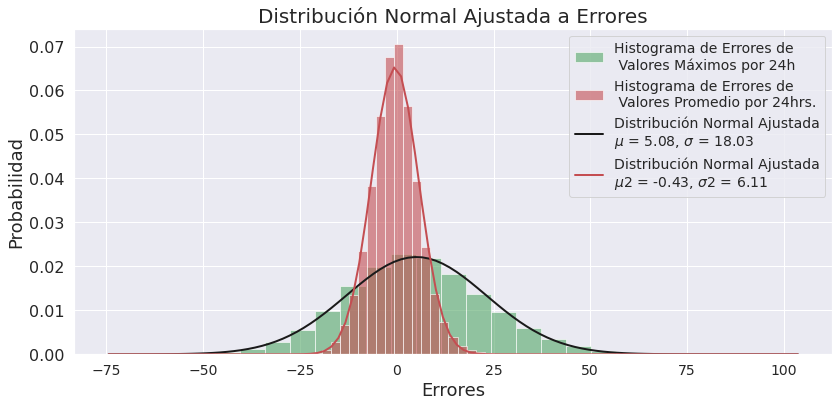

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


overall_errors = []

# Loop over the dictionary keys and values
for columna, values in errors_dict.items():
    max_y_true = values['max_y_true']
    max_y_pred = values['max_y_pred']
    errors = max_y_true - max_y_pred

    # Filtering out zeros
    for error in errors:
        if error != 0:
            overall_errors.append(error)

# Convert to numpy array for easier statistical analysis
overall_errors = np.array(overall_errors)

# Fit a normal distribution to the errors data
mu, std = norm.fit(overall_errors)

# Adjusting the size of the plot and font sizes for publication
plt.figure(figsize=(12, 6))  
plt.rcParams.update({'font.size': 18}) 

# Create a histogram of the errors
plt.hist(overall_errors, bins=25, density=True, alpha=0.6, color='g', label="Histograma de Errores de\n Valores Máximos por 24h")

# Create a PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

overall_errors2 = []

# Loop over the dictionary keys and values
for columna, values in errors_dict.items():
    max_y_true = values['mean_y_true']
    max_y_pred = values['mean_y_pred']
    errors = max_y_true - max_y_pred

    # Filtering out zeros
    for error in errors:
        if error != 0:
            overall_errors2.append(error)

# Convert to numpy array for easier statistical analysis
overall_errors2 = np.array(overall_errors2)

plt.hist(overall_errors2, bins=25, density=True, alpha=0.6, color='r', label="Histograma de Errores de\n Valores Promedio por 24hrs.")

mu2, std2 = norm.fit(overall_errors2)
p2 = norm.pdf(x, mu2, std2)

plt.plot(x, p, 'k', linewidth=2, label=f"Distribución Normal Ajustada\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
plt.plot(x, p2, 'r', linewidth=2, label=f"Distribución Normal Ajustada\n$\mu2$ = {mu2:.2f}, $\sigma2$ = {std2:.2f}")

plt.xlabel("Errores", fontsize=18)
plt.ylabel("Probabilidad", fontsize=18)
plt.title("Distribución Normal Ajustada a Errores", fontsize=20)

#plt.plot(x, p, 'k', linewidth=2, label=f"Fitted Normal Dist\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
#plt.plot(x, p2, 'r', linewidth=2, label=f"Fitted Normal Dist\n$\mu2$ = {mu2:.2f}, $\sigma2$ = {std2:.2f}")

#plt.xlabel("Errors", fontsize=18)
#plt.ylabel("Probability", fontsize=18)
#plt.title("Fitted Normal Distribution to Errors", fontsize=20)

plt.legend(fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=16)

plt.tight_layout()

# Uncomment the following line to save the figure
# plt.savefig('path_to_save_figure.png', dpi=300)

plt.show()


## <a id="Overall_Results_Table">Overall Results Table</a>
- [Return to Plots Index](#Plots_index)  

In [41]:
# Overall values of results for the model
overall = results_df.mean()
print(overall)


Correlation Index     8.809097e-01
MAE                   9.540290e+00
MAPE                  1.647712e+14
MSE                   1.600283e+02
RMSE                  1.256765e+01
R2                    7.567871e-01
Index of agreement    9.223043e-01
h24_max_err_mean      5.209274e+00
h24_max_err_std       1.698025e+01
h24_mean_err_mean    -4.149484e-01
h24_mean_err_std      5.749001e+00
dtype: float64
